# Faster R-CNN Playground

* Training a detector is very complicated. This notebook covers only the basic lists of items in Faster RCNN and still easily ends up with 1000+ lines of code. So please take your time going through every section.
* In detection, everything matters. For example, model architectures, weight initialization, loss functions, convolution types, etc. 
* Testing a detector on images is however easier, just load the weights and feed in the images.
* Pytorch now has built in detection models like Faster RCNN. 
* <font color='red'>__Please note that this is goint to be a huge Notebook__, not something that can be finished over breakfast!!!</font>

__Prerequisites__:
- numpy
- pytorch >=1.4.0
- torchvision >= 1.4.0
- pycocotools
- opencv
- matplotlib
- mmcv

__Dataset__:
- MS COCO

__HardWare__:
- NVIDIA CUDA GPU (at least one)      `# TODO: Add multi-gpu functionalities.`

## We will be reviewing Faster RCNN in several of the following sections from bottom to up levels.
1. Utils: basic deep learning operations and functions
2. Backbone: The model backbone and its building blocks.
3. Neck: Feature Pyramid Network.
4. Losses
5. Region Proposal Network Head.
6. RoI Extractor.
7. Bounding Box Head.
8. Faster RCNN.

## Now, Sit tight and let's get started!

In [1]:
import os
import logging
import warnings
import functools
import pkgutil
import torch
import torchvision
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F

from importlib import import_module
from collections import OrderedDict
from torch.nn.modules.batchnorm import _BatchNorm
from torch.utils import model_zoo

## Utils
1. Weight Initialization
2. BatchNorm Layer
3. ConvModule

__First we write some of the weight initialization methods__.

In [2]:
# ================================== weight_init ==================================

def constant_init(module, val, bias=0):
    if hasattr(module, 'weight') and module.weight is not None:
        nn.init.constant_(module.weight, val)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

def xavier_init(module, gain=1, bias=0, distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.xavier_uniform_(module.weight, gain=gain)
    else:
        nn.init.xavier_normal_(module.weight, gain=gain)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

def normal_init(module, mean=0, std=1, bias=0):
    nn.init.normal_(module.weight, mean, std)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

def uniform_init(module, a=0, b=1, bias=0):
    nn.init.uniform_(module.weight, a, b)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

def kaiming_init(module,
                 a=0,
                 mode='fan_out',
                 nonlinearity='relu',
                 bias=0,
                 distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.kaiming_uniform_(
            module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    else:
        nn.init.kaiming_normal_(
            module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)
        

Then, Different types of batch normalizations. Having these in your backbone makes huge differences. It usually requires a specific pre-trained ImageNet model.
1. The common one is __BatchNorm2d__. 
2. __SyncBN__ is intended for faster running speed across huge GPU clusters, it is a hack for BatchNorm2d.
3. __GroupNorm__ is another type of batch normalization. __GN__ divides the channels into groups and computes within each group the mean and variance for normalization. This way, __GN__ is less subjected to the batch size and make the performance stable across a wide range of batch size used. However, __GN__ uses more GPU memory and makes the algorithm slower. Usually ~1 AP point applied to ResNet50.

In [3]:
# ================================== norm_layers ==================================
norm_cfg = {
    # format: layer_type: (abbreviation, module)
    'BN': ('bn', nn.BatchNorm2d),
    'SyncBN': ('bn', nn.SyncBatchNorm),
    'GN': ('gn', nn.GroupNorm),
    # and potentially 'SN'
}

def build_norm_layer(cfg, num_features, postfix=''):
    """ Build normalization layer

    Args:
        cfg (dict): cfg should contain:
            type (str): identify norm layer type.
            layer args: args needed to instantiate a norm layer.
            requires_grad (bool): [optional] whether stop gradient updates
        num_features (int): number of channels from input.
        postfix (int, str): appended into norm abbreviation to
            create named layer.

    Returns:
        name (str): abbreviation + postfix
        layer (nn.Module): created norm layer
    """
    assert isinstance(cfg, dict) and 'type' in cfg
    cfg_ = cfg.copy()

    layer_type = cfg_.pop('type')
    if layer_type not in norm_cfg:
        raise KeyError('Unrecognized norm type {}'.format(layer_type))
    else:
        abbr, norm_layer = norm_cfg[layer_type]
        if norm_layer is None:
            raise NotImplementedError

    assert isinstance(postfix, (int, str))
    name = abbr + str(postfix)

    requires_grad = cfg_.pop('requires_grad', True)
    cfg_.setdefault('eps', 1e-5)
    if layer_type != 'GN':
        layer = norm_layer(num_features, **cfg_)
        if layer_type == 'SyncBN':
            layer._specify_ddp_gpu_num(1)
    else:
        assert 'num_groups' in cfg_
        layer = norm_layer(num_channels=num_features, **cfg_)

    for param in layer.parameters():
        param.requires_grad = requires_grad

    return name, layer

## Conv Methods:
1. Conv2d
2. TODO: ConvWS2d, usually applied with __GN__.
3. ConvModule: a wrapper function with for a conv layer (conv + norm + act). Nothing fancy here.

In [4]:
# ================================== conv_layers ==================================

conv_cfg = {
    'Conv': nn.Conv2d,
    # 'ConvWS': ConvWS2d,
    # TODO: octave conv
}

def build_conv_layer(cfg, *args, **kwargs):
    """ Build convolution layer

    Args:
        cfg (None or dict): cfg should contain:
            type (str): identify conv layer type.
            layer args: args needed to instantiate a conv layer.

    Returns:
        layer (nn.Module): created conv layer
    """
    if cfg is None:
        cfg_ = dict(type='Conv')
    else:
        assert isinstance(cfg, dict) and 'type' in cfg
        cfg_ = cfg.copy()

    layer_type = cfg_.pop('type')
    if layer_type not in conv_cfg:
        raise KeyError('Unrecognized norm type {}'.format(layer_type))
    else:
        conv_layer = conv_cfg[layer_type]

    layer = conv_layer(*args, **kwargs, **cfg_)

    return layer


class ConvModule(nn.Module):
    """A conv block that contains conv/norm/activation layers.

    Args:
        in_channels (int): Same as nn.Conv2d.
        out_channels (int): Same as nn.Conv2d.
        kernel_size (int or tuple[int]): Same as nn.Conv2d.
        stride (int or tuple[int]): Same as nn.Conv2d.
        padding (int or tuple[int]): Same as nn.Conv2d.
        dilation (int or tuple[int]): Same as nn.Conv2d.
        groups (int): Same as nn.Conv2d.
        bias (bool or str): If specified as `auto`, it will be decided by the
            norm_cfg. Bias will be set as True if norm_cfg is None, otherwise
            False.
        conv_cfg (dict): Config dict for convolution layer.
        norm_cfg (dict): Config dict for normalization layer.
        activation (str or None): Activation type, "ReLU" by default.
        inplace (bool): Whether to use inplace mode for activation.
        order (tuple[str]): The order of conv/norm/activation layers. It is a
            sequence of "conv", "norm" and "act". Examples are
            ("conv", "norm", "act") and ("act", "conv", "norm").
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias='auto',
                 conv_cfg=None,
                 norm_cfg=None,
                 activation='relu',
                 inplace=True,
                 order=('conv', 'norm', 'act')):
        super(ConvModule, self).__init__()
        assert conv_cfg is None or isinstance(conv_cfg, dict)
        assert norm_cfg is None or isinstance(norm_cfg, dict)
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.activation = activation
        self.inplace = inplace
        self.order = order
        assert isinstance(self.order, tuple) and len(self.order) == 3
        assert set(order) == set(['conv', 'norm', 'act'])

        self.with_norm = norm_cfg is not None
        self.with_activatation = activation is not None
        # if the conv layer is before a norm layer, bias is unnecessary.
        if bias == 'auto':
            bias = False if self.with_norm else True
        self.with_bias = bias

        if self.with_norm and self.with_bias:
            warnings.warn('ConvModule has norm and bias at the same time')

        # build convolution layer
        self.conv = build_conv_layer(
            conv_cfg,
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        # export the attributes of self.conv to a higher level for convenience
        self.in_channels = self.conv.in_channels
        self.out_channels = self.conv.out_channels
        self.kernel_size = self.conv.kernel_size
        self.stride = self.conv.stride
        self.padding = self.conv.padding
        self.dilation = self.conv.dilation
        self.transposed = self.conv.transposed
        self.output_padding = self.conv.output_padding
        self.groups = self.conv.groups

        # build normalization layers
        if self.with_norm:
            # norm layer is after conv layer
            if order.index('norm') > order.index('conv'):
                norm_channels = out_channels
            else:
                norm_channels = in_channels
            self.norm_name, norm = build_norm_layer(norm_cfg, norm_channels)
            self.add_module(self.norm_name, norm)

        # build activation layer
        if self.with_activatation:
            # TODO: introduce `act_cfg` and supports more activation layers
            if self.activation not in ['relu']:
                raise ValueError('{} is currently not supported.'.format(
                    self.activation))
            if self.activation == 'relu':
                self.activate = nn.ReLU(inplace=inplace)

        # Use msra init by default
        self.init_weights()

    @property
    def norm(self):
        return getattr(self, self.norm_name)

    def init_weights(self):
        nonlinearity = 'relu' if self.activation is None else self.activation
        kaiming_init(self.conv, nonlinearity=nonlinearity)
        if self.with_norm:
            constant_init(self.norm, 1, bias=0)

    def forward(self, x, activate=True, norm=True):
        for layer in self.order:
            if layer == 'conv':
                x = self.conv(x)
            elif layer == 'norm' and norm and self.with_norm:
                x = self.norm(x)
            elif layer == 'act' and activate and self.with_activatation:
                x = self.activate(x)
        return x

### Pre-trained weights loading

In [5]:
def load_state_dict(module, state_dict, strict=False, logger=None):
    """Load state_dict to a module.
    This method is modified from :meth:`torch.nn.Module.load_state_dict`.
    Default value for ``strict`` is set to ``False`` and the message for
    param mismatch will be shown even if strict is False.
    Args:
        module (Module): Module that receives the state_dict.
        state_dict (OrderedDict): Weights.
        strict (bool): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``False``.
        logger (:obj:`logging.Logger`, optional): Logger to log the error
            message. If not specified, print function will be used.
    """
    unexpected_keys = []
    all_missing_keys = []
    err_msg = []

    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    # use _load_from_state_dict to enable checkpoint version control
    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(state_dict, prefix, local_metadata, True,
                                     all_missing_keys, unexpected_keys,
                                     err_msg)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')

    load(module)
    load = None  # break load->load reference cycle

    # ignore "num_batches_tracked" of BN layers
    missing_keys = [
        key for key in all_missing_keys if 'num_batches_tracked' not in key
    ]

    if unexpected_keys:
        err_msg.append('unexpected key in source state_dict: {}\n'.format(
            ', '.join(unexpected_keys)))
    if missing_keys:
        err_msg.append('missing keys in source state_dict: {}\n'.format(
            ', '.join(missing_keys)))

    if len(err_msg) > 0:
        err_msg.insert(
            0, 'The model and loaded state dict do not match exactly\n')
        err_msg = '\n'.join(err_msg)
        if strict:
            raise RuntimeError(err_msg)
        elif logger is not None:
            logger.warning(err_msg)
        else:
            print(err_msg)

            
def get_torchvision_models():
    model_urls = dict()
    for _, name, ispkg in pkgutil.walk_packages(torchvision.models.__path__):
        if ispkg:
            continue
        _zoo = import_module('torchvision.models.{}'.format(name))
        if hasattr(_zoo, 'model_urls'):
            _urls = getattr(_zoo, 'model_urls')
            model_urls.update(_urls)
    return model_urls


def load_url_dist(url):
    """ In distributed setting, this function only download checkpoint at
    local rank 0 """
    checkpoint = model_zoo.load_url(url)
    return checkpoint


def _load_checkpoint(filename, map_location=None):
    """Load checkpoint from somewhere (modelzoo, file, url).
    Args:
        filename (str): Either a filepath or URI.
        map_location (str | None): Same as :func:`torch.load`. Default: None.
    Returns:
        dict | OrderedDict: The loaded checkpoint. It can be either an
            OrderedDict storing model weights or a dict containing other
            information, which depends on the checkpoint.
    """
    if filename.startswith('torchvision://'):
        model_urls = get_torchvision_models()
        model_name = filename[14:]
        checkpoint = load_url_dist(model_urls[model_name])
    else:
        if not os.path.isfile(filename):
            raise IOError('{} is not a checkpoint file'.format(filename))
        checkpoint = torch.load(filename, map_location=map_location)
    return checkpoint


def load_checkpoint(model,
                    filename,
                    map_location=None,
                    strict=False,
                    logger=None):
    """Load checkpoint from a file or URI.
    Args:
        model (Module): Module to load checkpoint.
        filename (str): Either a filepath or URL or modelzoo://xxxxxxx.
        map_location (str): Same as :func:`torch.load`.
        strict (bool): Whether to allow different params for the model and
            checkpoint.
        logger (:mod:`logging.Logger` or None): The logger for error message.
    Returns:
        dict or OrderedDict: The loaded checkpoint.
    """
    checkpoint = _load_checkpoint(filename, map_location)
    # get state_dict from checkpoint
    if isinstance(checkpoint, OrderedDict):
        state_dict = checkpoint
    elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        raise RuntimeError(
            'No state_dict found in checkpoint file {}'.format(filename))
    # strip prefix of state_dict
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k[7:]: v for k, v in checkpoint['state_dict'].items()}
    # load state_dict
    if hasattr(model, 'module'):
        load_state_dict(model.module, state_dict, strict, logger)
    else:
        load_state_dict(model, state_dict, strict, logger)
    return checkpoint

## Backbone
* Here we use __ResNet50__ as an example. We skipped the BasicBlock for ResNet18 & ResNet34 because they are rarely used in object detection.
* ResNet has the following structures (see Figure).
* The original Faster RCNN only use ___layer3___ as its output. This is not very efficient for multi-scale object detection. Later, Feature Pyramid Network (FPN) comes into play.
<img src="resnet_main.png" alt="An Overview of the ResNet Architecture" title="ResNet" />

In [6]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 dilation=1,
                 downsample=None,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN')):

        """Bottleneck block for ResNet.
        """
        super(Bottleneck, self).__init__()

        self.inplanes = inplanes
        self.planes = planes
        self.stride = stride
        self.dilation = dilation

        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg

        self.conv1_stride = 1
        self.conv2_stride = stride

        self.norm1_name, norm1 = build_norm_layer(norm_cfg, planes, postfix=1)
        self.norm2_name, norm2 = build_norm_layer(norm_cfg, planes, postfix=2)
        self.norm3_name, norm3 = build_norm_layer(norm_cfg, planes * self.expansion, postfix=3)

        self.conv1 = build_conv_layer(
            conv_cfg,
            inplanes,
            planes,
            kernel_size=1,
            stride=self.conv1_stride,
            bias=False)
        self.add_module(self.norm1_name, norm1)

        self.conv2 = build_conv_layer(
                conv_cfg,
                planes,
                planes,
                kernel_size=3,
                stride=self.conv2_stride,
                padding=dilation,
                dilation=dilation,
                bias=False)
        
        self.add_module(self.norm2_name, norm2)
        self.conv3 = build_conv_layer(
            conv_cfg,
            planes,
            planes * self.expansion,
            kernel_size=1,
            bias=False)
        self.add_module(self.norm3_name, norm3)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    @property
    def norm1(self):
        return getattr(self, self.norm1_name)

    @property
    def norm2(self):
        return getattr(self, self.norm2_name)

    @property
    def norm3(self):
        return getattr(self, self.norm3_name)

    def forward(self, x):

        def _inner_forward(x):
            identity = x

            out = self.conv1(x)
            out = self.norm1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.norm2(out)
            out = self.relu(out)

            out = self.conv3(out)
            out = self.norm3(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out += identity

            return out

        out = _inner_forward(x)
        out = self.relu(out)

        return out


def make_res_layer(block,
                   inplanes,
                   planes,
                   blocks,
                   stride=1,
                   dilation=1,
                   conv_cfg=None,
                   norm_cfg=dict(type='BN')):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            build_conv_layer(
                conv_cfg,
                inplanes,
                planes * block.expansion,
                kernel_size=1,
                stride=stride,
                bias=False),
            build_norm_layer(norm_cfg, planes * block.expansion)[1],
        )

    layers = []
    layers.append(
        block(
            inplanes=inplanes,
            planes=planes,
            stride=stride,
            dilation=dilation,
            downsample=downsample,
            conv_cfg=conv_cfg,
            norm_cfg=norm_cfg))
    inplanes = planes * block.expansion
    for i in range(1, blocks):
        layers.append(
            block(
                inplanes=inplanes,
                planes=planes,
                stride=1,
                dilation=dilation,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg))

    return nn.Sequential(*layers)

In [7]:
class ResNet(nn.Module):
    """ResNet backbone.

    Args:
        depth (int): Depth of resnet, from {18, 34, 50, 101, 152}.
        num_stages (int): Resnet stages, normally 4.
        strides (Sequence[int]): Strides of the first block of each stage.
        dilations (Sequence[int]): Dilation of each stage.
        out_indices (Sequence[int]): Output from which stages.
        style (str): `pytorch` or `caffe`. If set to "pytorch", the stride-two
            layer is the 3x3 conv layer, otherwise the stride-two layer is
            the first 1x1 conv layer.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters.
        norm_cfg (dict): dictionary to construct and config norm layer.
        norm_eval (bool): Whether to set norm layers to eval mode, namely,
            freeze running stats (mean and var). Note: Effect on Batch Norm
            and its variants only.
        zero_init_residual (bool): whether to use zero init for last norm layer
            in resblocks to let them behave as identity.
    """

    arch_settings = {
        # 18: (BasicBlock, (2, 2, 2, 2)),
        # 34: (BasicBlock, (3, 4, 6, 3)),
        50: (Bottleneck, (3, 4, 6, 3)),
        101: (Bottleneck, (3, 4, 23, 3)),
        152: (Bottleneck, (3, 8, 36, 3))
    }

    def __init__(self,
                 depth,
                 num_stages=4,
                 strides=(1, 2, 2, 2),
                 dilations=(1, 1, 1, 1),
                 out_indices=(0, 1, 2, 3),
                 frozen_stages=-1,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN', requires_grad=True),
                 norm_eval=True,
                 zero_init_residual=True):
        super(ResNet, self).__init__()
        if depth not in self.arch_settings:
            raise KeyError('invalid depth {} for resnet'.format(depth))
        self.depth = depth
        self.num_stages = num_stages
        assert num_stages >= 1 and num_stages <= 4
        self.strides = strides
        self.dilations = dilations
        assert len(strides) == len(dilations) == num_stages
        self.out_indices = out_indices
        assert max(out_indices) < num_stages
        self.frozen_stages = frozen_stages
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.norm_eval = norm_eval

        self.zero_init_residual = zero_init_residual
        self.block, stage_blocks = self.arch_settings[depth]
        self.stage_blocks = stage_blocks[:num_stages]
        self.inplanes = 64

        self._make_stem_layer()

        self.res_layers = []
        for i, num_blocks in enumerate(self.stage_blocks):
            stride = strides[i]
            dilation = dilations[i]
            planes = 64 * 2**i
            res_layer = make_res_layer(
                self.block,
                self.inplanes,
                planes,
                num_blocks,
                stride=stride,
                dilation=dilation,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg)
            self.inplanes = planes * self.block.expansion
            layer_name = 'layer{}'.format(i + 1)
            self.add_module(layer_name, res_layer)
            self.res_layers.append(layer_name)

        self._freeze_stages()

        self.feat_dim = self.block.expansion * 64 * 2**(
            len(self.stage_blocks) - 1)

    @property
    def norm1(self):
        return getattr(self, self.norm1_name)

    def _make_stem_layer(self):
        self.conv1 = build_conv_layer(
            self.conv_cfg,
            3,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False)
        self.norm1_name, norm1 = build_norm_layer(self.norm_cfg, 64, postfix=1)
        self.add_module(self.norm1_name, norm1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def _freeze_stages(self):
        if self.frozen_stages >= 0:
            self.norm1.eval()
            for m in [self.conv1, self.norm1]:
                for param in m.parameters():
                    param.requires_grad = False

        for i in range(1, self.frozen_stages + 1):
            m = getattr(self, 'layer{}'.format(i))
            m.eval()
            for param in m.parameters():
                param.requires_grad = False

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = logging.getLogger()
            load_checkpoint(self, pretrained, strict=False, logger=logger)
        elif pretrained is None:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    kaiming_init(m)
                elif isinstance(m, (_BatchNorm, nn.GroupNorm)):
                    constant_init(m, 1)

            if self.zero_init_residual:
                for m in self.modules():
                    if isinstance(m, Bottleneck):
                        constant_init(m.norm3, 0)
                    elif isinstance(m, BasicBlock):
                        constant_init(m.norm2, 0)
        else:
            raise TypeError('pretrained must be a str or None')

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        outs = []
        for i, layer_name in enumerate(self.res_layers):
            res_layer = getattr(self, layer_name)
            x = res_layer(x)
            if i in self.out_indices:
                outs.append(x)
        return tuple(outs)

    def train(self, mode=True):
        super(ResNet, self).train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                # trick: eval have effect on BatchNorm only
                if isinstance(m, _BatchNorm):
                    m.eval()

<div class="alert alert-block alert-info">
<b>NOTE:</b> You can initialize a ResNet50 model here to see how the model actually
looks like in PyTorch.
</div>

In [8]:
backbone = ResNet(50)
print(backbone)
del backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## NECK MODULE
* In this section, we will use Feature Pyramid Network as an example. Nowadays, Feature Pyramid Network becomes the standard components of the SOTA object detection algorithms.
* In Faster RCNN, the RPN can take input from a single layer or it can take inputs of 4 layers from the FPN.

In [9]:
class FPN(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs,
                 start_level=0,
                 end_level=-1,
                 add_extra_convs=False,
                 extra_convs_on_inputs=True,
                 relu_before_extra_convs=False,
                 no_norm_on_lateral=False,
                 conv_cfg=None,
                 norm_cfg=None,
                 activation=None):
        super(FPN, self).__init__()
        assert isinstance(in_channels, list)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_ins = len(in_channels)
        self.num_outs = num_outs
        self.activation = activation
        self.relu_before_extra_convs = relu_before_extra_convs
        self.no_norm_on_lateral = no_norm_on_lateral

        if end_level == -1:
            self.backbone_end_level = self.num_ins
            assert num_outs >= self.num_ins - start_level
        else:
            # if end_level < inputs, no extra level is allowed
            self.backbone_end_level = end_level
            assert end_level <= len(in_channels)
            assert num_outs == end_level - start_level
        self.start_level = start_level
        self.end_level = end_level
        self.add_extra_convs = add_extra_convs
        self.extra_convs_on_inputs = extra_convs_on_inputs

        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()

        for i in range(self.start_level, self.backbone_end_level):
            l_conv = ConvModule(
                in_channels[i],
                out_channels,
                1,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg if not self.no_norm_on_lateral else None,
                activation=self.activation,
                inplace=False)
            fpn_conv = ConvModule(
                out_channels,
                out_channels,
                3,
                padding=1,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg,
                activation=self.activation,
                inplace=False)

            self.lateral_convs.append(l_conv)
            self.fpn_convs.append(fpn_conv)

        # add extra conv layers (e.g., RetinaNet)
        extra_levels = num_outs - self.backbone_end_level + self.start_level
        if add_extra_convs and extra_levels >= 1:
            for i in range(extra_levels):
                if i == 0 and self.extra_convs_on_inputs:
                    in_channels = self.in_channels[self.backbone_end_level - 1]
                else:
                    in_channels = out_channels
                extra_fpn_conv = ConvModule(
                    in_channels,
                    out_channels,
                    3,
                    stride=2,
                    padding=1,
                    conv_cfg=conv_cfg,
                    norm_cfg=norm_cfg,
                    activation=self.activation,
                    inplace=False)
                self.fpn_convs.append(extra_fpn_conv)

    # default init_weights for conv(msra) and norm in ConvModule
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                xavier_init(m, distribution='uniform')

    def forward(self, inputs):
        assert len(inputs) == len(self.in_channels)

        # build laterals
        laterals = [
            lateral_conv(inputs[i + self.start_level])
            for i, lateral_conv in enumerate(self.lateral_convs)
        ]

        # build top-down path
        used_backbone_levels = len(laterals)
        for i in range(used_backbone_levels - 1, 0, -1):
            laterals[i - 1] += F.interpolate(
                laterals[i], scale_factor=2, mode='nearest')

        # build outputs
        # part 1: from original levels
        outs = [
            self.fpn_convs[i](laterals[i]) for i in range(used_backbone_levels)
        ]
        # part 2: add extra levels
        if self.num_outs > len(outs):
            # use max pool to get more levels on top of outputs
            # (e.g., Faster R-CNN, Mask R-CNN)
            if not self.add_extra_convs:
                for i in range(self.num_outs - used_backbone_levels):
                    outs.append(F.max_pool2d(outs[-1], 1, stride=2))
            # add conv layers on top of original feature maps (RetinaNet)
            else:
                if self.extra_convs_on_inputs:
                    orig = inputs[self.backbone_end_level - 1]
                    outs.append(self.fpn_convs[used_backbone_levels](orig))
                else:
                    outs.append(self.fpn_convs[used_backbone_levels](outs[-1]))
                for i in range(used_backbone_levels + 1, self.num_outs):
                    if self.relu_before_extra_convs:
                        outs.append(self.fpn_convs[i](F.relu(outs[-1])))
                    else:
                        outs.append(self.fpn_convs[i](outs[-1]))
        return tuple(outs)

For Faster RCNN, FPN takes the last 4 stages (C1, C2, C3, C4) from ResNet, with channels [256, 512, 1024, 2048].

<div class="alert alert-block alert-info">
<b>NOTE:</b> Again, you can print out an FPN here in PyTorch.
</div>

In [10]:
neck = FPN(
    in_channels=[256, 512, 1024, 2048],
    out_channels=256, 
    num_outs=5)
print(neck)
del neck

FPN(
  (lateral_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvModule(
      (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ConvModule(
      (conv): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (fpn_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


## Region Proposal Network
We will devide this in several parts: Anchor Modules, Loss Functions and Anchor Heads.

### Anchor Modules

<div class="alert alert-block alert-info">
<b>NOTE:</b> Here we define some helper functions.
</div>

In [11]:
class AnchorGenerator(object):

    def __init__(self, base_size, scales, ratios, scale_major=True, ctr=None):
        self.base_size = base_size
        self.scales = torch.Tensor(scales)
        self.ratios = torch.Tensor(ratios)
        self.scale_major = scale_major
        self.ctr = ctr
        self.base_anchors = self.gen_base_anchors()

    @property
    def num_base_anchors(self):
        return self.base_anchors.size(0)

    def gen_base_anchors(self):
        w = self.base_size
        h = self.base_size
        if self.ctr is None:
            x_ctr = 0.5 * (w - 1)
            y_ctr = 0.5 * (h - 1)
        else:
            x_ctr, y_ctr = self.ctr

        h_ratios = torch.sqrt(self.ratios)
        w_ratios = 1 / h_ratios
        if self.scale_major:
            ws = (w * w_ratios[:, None] * self.scales[None, :]).view(-1)
            hs = (h * h_ratios[:, None] * self.scales[None, :]).view(-1)
        else:
            ws = (w * self.scales[:, None] * w_ratios[None, :]).view(-1)
            hs = (h * self.scales[:, None] * h_ratios[None, :]).view(-1)

        # yapf: disable
        base_anchors = torch.stack(
            [
                x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
                x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
            ],
            dim=-1).round()
        # yapf: enable

        return base_anchors

    def _meshgrid(self, x, y, row_major=True):
        xx = x.repeat(len(y))
        yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
        if row_major:
            return xx, yy
        else:
            return yy, xx

    def grid_anchors(self, featmap_size, stride=16, device='cuda'):
        base_anchors = self.base_anchors.to(device)

        feat_h, feat_w = featmap_size
        shift_x = torch.arange(0, feat_w, device=device) * stride
        shift_y = torch.arange(0, feat_h, device=device) * stride
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
        shifts = shifts.type_as(base_anchors)
        # first feat_w elements correspond to the first row of shifts
        # add A anchors (1, A, 4) to K shifts (K, 1, 4) to get
        # shifted anchors (K, A, 4), reshape to (K*A, 4)

        all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
        all_anchors = all_anchors.view(-1, 4)
        # first A rows correspond to A anchors of (0, 0) in feature map,
        # then (0, 1), (0, 2), ...
        return all_anchors

    def valid_flags(self, featmap_size, valid_size, device='cuda'):
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w, dtype=torch.uint8, device=device)
        valid_y = torch.zeros(feat_h, dtype=torch.uint8, device=device)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        valid = valid[:, None].expand(
            valid.size(0), self.num_base_anchors).contiguous().view(-1)
        return valid

In [12]:
from functools import partial
from six.moves import map, zip
from torchvision.ops import nms as tv_nms

def multi_apply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
    return tuple(map(list, zip(*map_results)))

def images_to_levels(target, num_level_anchors):
    """Convert targets by image to targets by feature level.
    [target_img0, target_img1] -> [target_level0, target_level1, ...]
    """
    target = torch.stack(target, 0)
    level_targets = []
    start = 0
    for n in num_level_anchors:
        end = start + n
        level_targets.append(target[:, start:end].squeeze(0))
        start = end
    return level_targets

def anchor_inside_flags(flat_anchors,
                        valid_flags,
                        img_shape,
                        allowed_border=0):
    img_h, img_w = img_shape[:2]
    if allowed_border >= 0:
        inside_flags = valid_flags & \
            (flat_anchors[:, 0] >= -allowed_border).type(torch.uint8) & \
            (flat_anchors[:, 1] >= -allowed_border).type(torch.uint8) & \
            (flat_anchors[:, 2] < img_w + allowed_border).type(torch.uint8) & \
            (flat_anchors[:, 3] < img_h + allowed_border).type(torch.uint8)
    else:
        inside_flags = valid_flags
    return inside_flags


def unmap(data, count, inds, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """
    if data.dim() == 1:
        ret = data.new_full((count, ), fill)
        ret[inds.type(torch.bool)] = data
    else:
        new_size = (count, ) + data.size()[1:]
        ret = data.new_full(new_size, fill)
        ret[inds.type(torch.bool), :] = data
    return ret


def bbox_overlaps(bboxes1, bboxes2, mode='iou', is_aligned=False):
    """Calculate overlap between two set of bboxes.

    If ``is_aligned`` is ``False``, then calculate the ious between each bbox
    of bboxes1 and bboxes2, otherwise the ious between each aligned pair of
    bboxes1 and bboxes2.

    Args:
        bboxes1 (Tensor): shape (m, 4)
        bboxes2 (Tensor): shape (n, 4), if is_aligned is ``True``, then m and n
            must be equal.
        mode (str): "iou" (intersection over union) or iof (intersection over
            foreground).

    Returns:
        ious(Tensor): shape (m, n) if is_aligned == False else shape (m, 1)
    """
    assert mode in ['iou', 'iof']

    rows = bboxes1.size(0)
    cols = bboxes2.size(0)
    if is_aligned:
        assert rows == cols

    if rows * cols == 0:
        return bboxes1.new(rows, 1) if is_aligned else bboxes1.new(rows, cols)

    if is_aligned:
        lt = torch.max(bboxes1[:, :2], bboxes2[:, :2])  # [rows, 2]
        rb = torch.min(bboxes1[:, 2:], bboxes2[:, 2:])  # [rows, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, 2]
        overlap = wh[:, 0] * wh[:, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1 + area2 - overlap)
        else:
            ious = overlap / area1
    else:
        lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2]
        rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
        overlap = wh[:, :, 0] * wh[:, :, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1[:, None] + area2 - overlap)
        else:
            ious = overlap / (area1[:, None])

    return ious


def bbox2delta(proposals, gt, means=[0, 0, 0, 0], stds=[1, 1, 1, 1]):
    assert proposals.size() == gt.size()

    proposals = proposals.float()
    gt = gt.float()
    px = (proposals[..., 0] + proposals[..., 2]) * 0.5
    py = (proposals[..., 1] + proposals[..., 3]) * 0.5
    pw = proposals[..., 2] - proposals[..., 0] + 1.0
    ph = proposals[..., 3] - proposals[..., 1] + 1.0

    gx = (gt[..., 0] + gt[..., 2]) * 0.5
    gy = (gt[..., 1] + gt[..., 3]) * 0.5
    gw = gt[..., 2] - gt[..., 0] + 1.0
    gh = gt[..., 3] - gt[..., 1] + 1.0

    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = torch.log(gw / pw)
    dh = torch.log(gh / ph)
    deltas = torch.stack([dx, dy, dw, dh], dim=-1)

    means = deltas.new_tensor(means).unsqueeze(0)
    stds = deltas.new_tensor(stds).unsqueeze(0)
    deltas = deltas.sub_(means).div_(stds)

    return deltas


def delta2bbox(rois,
               deltas,
               means=[0, 0, 0, 0],
               stds=[1, 1, 1, 1],
               max_shape=None,
               wh_ratio_clip=16 / 1000):
    means = deltas.new_tensor(means).repeat(1, deltas.size(1) // 4)
    stds = deltas.new_tensor(stds).repeat(1, deltas.size(1) // 4)
    denorm_deltas = deltas * stds + means
    dx = denorm_deltas[:, 0::4]
    dy = denorm_deltas[:, 1::4]
    dw = denorm_deltas[:, 2::4]
    dh = denorm_deltas[:, 3::4]
    max_ratio = np.abs(np.log(wh_ratio_clip))
    dw = dw.clamp(min=-max_ratio, max=max_ratio)
    dh = dh.clamp(min=-max_ratio, max=max_ratio)
    px = ((rois[:, 0] + rois[:, 2]) * 0.5).unsqueeze(1).expand_as(dx)
    py = ((rois[:, 1] + rois[:, 3]) * 0.5).unsqueeze(1).expand_as(dy)
    pw = (rois[:, 2] - rois[:, 0] + 1.0).unsqueeze(1).expand_as(dw)
    ph = (rois[:, 3] - rois[:, 1] + 1.0).unsqueeze(1).expand_as(dh)
    gw = pw * dw.exp()
    gh = ph * dh.exp()
    gx = torch.addcmul(px, 1, pw, dx)  # gx = px + pw * dx
    gy = torch.addcmul(py, 1, ph, dy)  # gy = py + ph * dy
    x1 = gx - gw * 0.5 + 0.5
    y1 = gy - gh * 0.5 + 0.5
    x2 = gx + gw * 0.5 - 0.5
    y2 = gy + gh * 0.5 - 0.5
    if max_shape is not None:
        x1 = x1.clamp(min=0, max=max_shape[1] - 1)
        y1 = y1.clamp(min=0, max=max_shape[0] - 1)
        x2 = x2.clamp(min=0, max=max_shape[1] - 1)
        y2 = y2.clamp(min=0, max=max_shape[0] - 1)
    bboxes = torch.stack([x1, y1, x2, y2], dim=-1).view_as(deltas)
    return bboxes


def bbox2roi(bbox_list):
    """Convert a list of bboxes to roi format.

    Args:
        bbox_list (list[Tensor]): a list of bboxes corresponding to a batch
            of images.

    Returns:
        Tensor: shape (n, 5), [batch_ind, x1, y1, x2, y2]
    """
    rois_list = []
    for img_id, bboxes in enumerate(bbox_list):
        if bboxes.size(0) > 0:
            img_inds = bboxes.new_full((bboxes.size(0), 1), img_id)
            rois = torch.cat([img_inds, bboxes[:, :4]], dim=-1)
        else:
            rois = bboxes.new_zeros((0, 5))
        rois_list.append(rois)
    rois = torch.cat(rois_list, 0)
    return rois


def roi2bbox(rois):
    bbox_list = []
    img_ids = torch.unique(rois[:, 0].cpu(), sorted=True)
    for img_id in img_ids:
        inds = (rois[:, 0] == img_id.item())
        bbox = rois[inds, 1:]
        bbox_list.append(bbox)
    return bbox_list


def bbox2result(bboxes, labels, num_classes):
    """Convert detection results to a list of numpy arrays.
    Args:
        bboxes (Tensor): shape (n, 5)
        labels (Tensor): shape (n, )
        num_classes (int): class number, including background class
    Returns:
        list(ndarray): bbox results of each class
    """
    if bboxes.shape[0] == 0:
        return [
            np.zeros((0, 5), dtype=np.float32) for i in range(num_classes - 1)
        ]
    else:
        bboxes = bboxes.cpu().numpy()
        labels = labels.cpu().numpy()
        return [bboxes[labels == i, :] for i in range(num_classes - 1)]


def nms(dets, iou_thr, device_id=None):
    """Dispatch to either CPU or GPU NMS implementations.

    The input can be either a torch tensor or numpy array. GPU NMS will be used
    if the input is a gpu tensor or device_id is specified, otherwise CPU NMS
    will be used. The returned type will always be the same as inputs.

    Arguments:
        dets (torch.Tensor or np.ndarray): bboxes with scores.
        iou_thr (float): IoU threshold for NMS.
        device_id (int, optional): when `dets` is a numpy array, if `device_id`
            is None, then cpu nms is used, otherwise gpu_nms will be used.

    Returns:
        tuple: kept bboxes and indice, which is always the same data type as
            the input.
    """
    # convert dets (tensor or numpy array) to tensor
    if isinstance(dets, torch.Tensor):
        is_numpy = False
        dets_th = dets[:, :4]
        scores_th = dets[:, -1]
    elif isinstance(dets, np.ndarray):
        is_numpy = True
        device = 'cpu' if device_id is None else 'cuda:{}'.format(device_id)
        dets_th = torch.from_numpy(dets[:, :4]).to(device)
        scores_th = torch.from_numpy(dets[:, -1]).to(device)
    else:
        raise TypeError(
            'dets must be either a Tensor or numpy array, but got {}'.format(
                type(dets)))

    # execute cpu or cuda nms
    if dets_th.shape[0] == 0:
        inds = dets_th.new_zeros(0, dtype=torch.long)
    else:
        if dets_th.is_cuda:
            inds = tv_nms(dets_th, scores_th, iou_thr)
        else:
            dets_th = dets_th.cuda()
            scores_th = scores_th.cuda()
            inds = tv_nms(dets_th, scores_th, iou_thr)
    if is_numpy:
        inds = inds.cpu().numpy()
    return dets[inds, :], inds
    


def multiclass_nms(multi_bboxes,
                   multi_scores,
                   score_thr,
                   nms_cfg,
                   max_num=-1,
                   score_factors=None):
    """NMS for multi-class bboxes.

    Args:
        multi_bboxes (Tensor): shape (n, #class*4) or (n, 4)
        multi_scores (Tensor): shape (n, #class)
        score_thr (float): bbox threshold, bboxes with scores lower than it
            will not be considered.
        nms_thr (float): NMS IoU threshold
        max_num (int): if there are more than max_num bboxes after NMS,
            only top max_num will be kept.
        score_factors (Tensor): The factors multiplied to scores before
            applying NMS

    Returns:
        tuple: (bboxes, labels), tensors of shape (k, 5) and (k, 1). Labels
            are 0-based.
    """
    nms_wrapper = {
        'nms': nms,
#         'soft_nms': soft_nms #TODO: Add Soft
    }

    num_classes = multi_scores.shape[1]
    bboxes, labels = [], []
    nms_cfg_ = nms_cfg.copy()
    nms_type = nms_cfg_.pop('type', 'nms')
    nms_op = nms_wrapper[nms_type]
    for i in range(1, num_classes):
        cls_inds = multi_scores[:, i] > score_thr
        if not cls_inds.any():
            continue
        # get bboxes and scores of this class
        if multi_bboxes.shape[1] == 4:
            _bboxes = multi_bboxes[cls_inds, :]
        else:
            _bboxes = multi_bboxes[cls_inds, i * 4:(i + 1) * 4]
        _scores = multi_scores[cls_inds, i]
        if score_factors is not None:
            _scores *= score_factors[cls_inds]
        cls_dets = torch.cat([_bboxes, _scores[:, None]], dim=1)
        cls_dets, _ = nms_op(cls_dets, **nms_cfg_)
        cls_labels = multi_bboxes.new_full((cls_dets.shape[0], ),
                                           i - 1,
                                           dtype=torch.long)
        bboxes.append(cls_dets)
        labels.append(cls_labels)
    if bboxes:
        bboxes = torch.cat(bboxes)
        labels = torch.cat(labels)
        if bboxes.shape[0] > max_num:
            _, inds = bboxes[:, -1].sort(descending=True)
            inds = inds[:max_num]
            bboxes = bboxes[inds]
            labels = labels[inds]
    else:
        bboxes = multi_bboxes.new_zeros((0, 5))
        labels = multi_bboxes.new_zeros((0, ), dtype=torch.long)

    return bboxes, labels

### Anchor Assigner
* The __anchor boxes__ or __anchor points__ are usually referred when it comes to efficient learning. They are simply the tools to help us find interesting locations in the feature maps. The anchor boxes are purely __conceptual__. 
* We generate __anchor boxes/ anchor points__ at every pixel location on the feature maps. The concept of anchor-free is not something convoluted but merely a change in the way how each pixel encodes information.

<div class="alert alert-block alert-success">
<b>NOTE:</b> Now let's cover the most common assigning strategy called the MaxIoUAssigner.
</div>

1. Set every anchor box as a __ignore__ class, meaning no gradient will be propagated!
2. Assign all proposals whose iou with all gts < _neg_iou_thr_ to the background class.
3. For each anchor box, if the iou with its nearest gt >= _pos_iou_thr_, assign it to that bbox.
4. For each gt bbox, assign its nearest proposals (may be more than one) to itself.
5. Collect all assignments.

In [13]:
class AssignResult(object):

    def __init__(self, num_gts, gt_inds, max_overlaps, labels=None):
        self.num_gts = num_gts
        self.gt_inds = gt_inds
        self.max_overlaps = max_overlaps
        self.labels = labels

    def add_gt_(self, gt_labels):
        self_inds = torch.arange(
            1, len(gt_labels) + 1, dtype=torch.long, device=gt_labels.device)
        self.gt_inds = torch.cat([self_inds, self.gt_inds])
        self.max_overlaps = torch.cat(
            [self.max_overlaps.new_ones(self.num_gts), self.max_overlaps])
        if self.labels is not None:
            self.labels = torch.cat([gt_labels, self.labels])


class MaxIoUAssigner(object):
    """Assign a corresponding gt bbox or background to each bbox.
    Each proposals will be assigned with `-1`, `0`, or a positive integer
    indicating the ground truth index.
    - -1: don't care
    - 0: negative sample, no assigned gt
    - positive integer: positive sample, index (1-based) of assigned gt
    Args:
        pos_iou_thr (float): IoU threshold for positive bboxes.
        neg_iou_thr (float or tuple): IoU threshold for negative bboxes.
        min_pos_iou (float): Minimum iou for a bbox to be considered as a
            positive bbox. Positive samples can have smaller IoU than
            pos_iou_thr due to the 4th step (assign max IoU sample to each gt).
        gt_max_assign_all (bool): Whether to assign all bboxes with the same
            highest overlap with some gt to that gt.
        ignore_iof_thr (float): IoF threshold for ignoring bboxes (if
            `gt_bboxes_ignore` is specified). Negative values mean not
            ignoring any bboxes.
        ignore_wrt_candidates (bool): Whether to compute the iof between
            `bboxes` and `gt_bboxes_ignore`, or the contrary.
        gpu_assign_thr (int): The upper bound of the number of GT for GPU
            assign. When the number of gt is above this threshold, will assign
            on CPU device. Negative values mean not assign on CPU.
    """
    def __init__(self,
                 pos_iou_thr=0.7,
                 neg_iou_thr=0.3,
                 min_pos_iou=0.3,
                 gt_max_assign_all=True,
                 ignore_iof_thr=-1,
                 ignore_wrt_candidates=True,
                 gpu_assign_thr=-1):
        self.pos_iou_thr = pos_iou_thr
        self.neg_iou_thr = neg_iou_thr
        self.min_pos_iou = min_pos_iou
        self.gt_max_assign_all = gt_max_assign_all
        self.ignore_iof_thr = ignore_iof_thr
        self.ignore_wrt_candidates = ignore_wrt_candidates
        self.gpu_assign_thr = gpu_assign_thr
        
    def assign(self, bboxes, gt_bboxes, gt_bboxes_ignore=None, gt_labels=None):
        """Assign gt to bboxes.
        This method assign a gt bbox to every bbox (proposal/anchor), each bbox
        will be assigned with -1, 0, or a positive number. -1 means don't care,
        0 means negative sample, positive number is the index (1-based) of
        assigned gt.
        The assignment is done in following steps, the order matters.
        1. assign every bbox to -1
        2. assign proposals whose iou with all gts < neg_iou_thr to 0
        3. for each bbox, if the iou with its nearest gt >= pos_iou_thr,
           assign it to that bbox
        4. for each gt bbox, assign its nearest proposals (may be more than
           one) to itself
        Args:
            bboxes (Tensor): Bounding boxes to be assigned, shape(n, 4).
            gt_bboxes (Tensor): Groundtruth boxes, shape (k, 4).
            gt_bboxes_ignore (Tensor, optional): Ground truth bboxes that are
                labelled as `ignored`, e.g., crowd boxes in COCO.
            gt_labels (Tensor, optional): Label of gt_bboxes, shape (k, ).
        Returns:
            :obj:`AssignResult`: The assign result.
        Example:
            >>> self = MaxIoUAssigner(0.5, 0.5)
            >>> bboxes = torch.Tensor([[0, 0, 10, 10], [10, 10, 20, 20]])
            >>> gt_bboxes = torch.Tensor([[0, 0, 10, 9]])
            >>> assign_result = self.assign(bboxes, gt_bboxes)
            >>> expected_gt_inds = torch.LongTensor([1, 0])
            >>> assert torch.all(assign_result.gt_inds == expected_gt_inds)
        """
        assign_on_cpu = True if (self.gpu_assign_thr > 0) and (
            gt_bboxes.shape[0] > self.gpu_assign_thr) else False
        # compute overlap and assign gt on CPU when number of GT is large
        if assign_on_cpu:
            device = bboxes.device
            bboxes = bboxes.cpu()
            gt_bboxes = gt_bboxes.cpu()
            if gt_bboxes_ignore is not None:
                gt_bboxes_ignore = gt_bboxes_ignore.cpu()
            if gt_labels is not None:
                gt_labels = gt_labels.cpu()

        bboxes = bboxes[:, :4]
        overlaps = bbox_overlaps(gt_bboxes, bboxes)

        if (self.ignore_iof_thr > 0 and gt_bboxes_ignore is not None
                and gt_bboxes_ignore.numel() > 0 and bboxes.numel() > 0):
            if self.ignore_wrt_candidates:
                ignore_overlaps = bbox_overlaps(
                    bboxes, gt_bboxes_ignore, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=1)
            else:
                ignore_overlaps = bbox_overlaps(
                    gt_bboxes_ignore, bboxes, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=0)
            overlaps[:, ignore_max_overlaps > self.ignore_iof_thr] = -1

        assign_result = self.assign_wrt_overlaps(overlaps, gt_labels)
        if assign_on_cpu:
            assign_result.gt_inds = assign_result.gt_inds.to(device)
            assign_result.max_overlaps = assign_result.max_overlaps.to(device)
            if assign_result.labels is not None:
                assign_result.labels = assign_result.labels.to(device)
        return assign_result

    def assign_wrt_overlaps(self, overlaps, gt_labels=None):
        """Assign w.r.t. the overlaps of bboxes with gts.
        Args:
            overlaps (Tensor): Overlaps between k gt_bboxes and n bboxes,
                shape(k, n).
            gt_labels (Tensor, optional): Labels of k gt_bboxes, shape (k, ).
        Returns:
            :obj:`AssignResult`: The assign result.
        """
        num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

        # 1. assign -1 by default
        assigned_gt_inds = overlaps.new_full((num_bboxes, ), -1, dtype=torch.long)

        if num_gts == 0 or num_bboxes == 0:
            # No ground truth or boxes, return empty assignment
            max_overlaps = overlaps.new_zeros((num_bboxes, ))
            if num_gts == 0:
                # No truth, assign everything to background
                assigned_gt_inds[:] = 0
            if gt_labels is None:
                assigned_labels = None
            else:
                assigned_labels = overlaps.new_zeros((num_bboxes, ),
                                                     dtype=torch.long)
            return AssignResult(
                num_gts,
                assigned_gt_inds,
                max_overlaps,
                labels=assigned_labels)

        # for each anchor, which gt best overlaps with it
        # for each anchor, the max iou of all gts
        max_overlaps, argmax_overlaps = overlaps.max(dim=0)
        # for each gt, which anchor best overlaps with it
        # for each gt, the max iou of all proposals
        gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

        # 2. assign negative: below
        if isinstance(self.neg_iou_thr, float):
            assigned_gt_inds[(max_overlaps >= 0)
                             & (max_overlaps < self.neg_iou_thr)] = 0
        elif isinstance(self.neg_iou_thr, tuple):
            assert len(self.neg_iou_thr) == 2
            assigned_gt_inds[(max_overlaps >= self.neg_iou_thr[0])
                             & (max_overlaps < self.neg_iou_thr[1])] = 0

        # 3. assign positive: above positive IoU threshold
        pos_inds = max_overlaps >= self.pos_iou_thr
        assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

        # 4. assign fg: for each gt, proposals with highest IoU
        for i in range(num_gts):
            if gt_max_overlaps[i] >= self.min_pos_iou:
                if self.gt_max_assign_all:
                    max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
                    assigned_gt_inds[max_iou_inds] = i + 1
                else:
                    assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1

        if gt_labels is not None:
            assigned_labels = assigned_gt_inds.new_zeros((num_bboxes, ))
            pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze()
            if pos_inds.numel() > 0:
                assigned_labels[pos_inds] = gt_labels[
                    assigned_gt_inds[pos_inds] - 1]
        else:
            assigned_labels = None

        return AssignResult(
            num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)    

### Anchor Sampler
* After acquiring all the assignments. We need to sample a batch of them for actual training.
* Depending on your choice of loss functions. Common strategies includes random sampling, balances sampling, sample all for _FocalLoss_, etc.
* Random sampling a balanced batch of ___pos/neg___ is used in the official Faster RCNN training.

In [14]:
class SamplingResult(object):

    def __init__(self, pos_inds, neg_inds, bboxes, gt_bboxes, assign_result,
                 gt_flags):
        self.pos_inds = pos_inds
        self.neg_inds = neg_inds
        self.pos_bboxes = bboxes[pos_inds]
        self.neg_bboxes = bboxes[neg_inds]
        self.pos_is_gt = gt_flags[pos_inds]

        self.num_gts = gt_bboxes.shape[0]
        self.pos_assigned_gt_inds = assign_result.gt_inds[pos_inds] - 1
        self.pos_gt_bboxes = gt_bboxes[self.pos_assigned_gt_inds, :]
        if assign_result.labels is not None:
            self.pos_gt_labels = assign_result.labels[pos_inds]
        else:
            self.pos_gt_labels = None

    @property
    def bboxes(self):
        return torch.cat([self.pos_bboxes, self.neg_bboxes])

class RandomSampler(object):

    def __init__(self,
                 num,
                 pos_fraction,
                 neg_pos_ub=-1,
                 add_gt_as_proposals=True,
                 **kwargs):
        self.num = num
        self.pos_fraction = pos_fraction
        self.neg_pos_ub = neg_pos_ub
        self.add_gt_as_proposals = add_gt_as_proposals
        
    @staticmethod
    def random_choice(gallery, num):
        """Random select some elements from the gallery.

        It seems that Pytorch's implementation is slower than numpy so we use
        numpy to randperm the indices.
        """
        assert len(gallery) >= num
        if isinstance(gallery, list):
            gallery = np.array(gallery)
        cands = np.arange(len(gallery))
        np.random.shuffle(cands)
        rand_inds = cands[:num]
        if not isinstance(gallery, np.ndarray):
            rand_inds = torch.from_numpy(rand_inds).long().to(gallery.device)
        return gallery[rand_inds]    
        
    def _sample_pos(self, assign_result, num_expected, **kwargs):
        """Randomly sample some positive samples."""
        pos_inds = torch.nonzero(assign_result.gt_inds > 0)
        if pos_inds.numel() != 0:
            pos_inds = pos_inds.squeeze(1)
        if pos_inds.numel() <= num_expected:
            return pos_inds
        else:
            return self.random_choice(pos_inds, num_expected)
        
    def _sample_neg(self, assign_result, num_expected, **kwargs):
        """Randomly sample some negative samples."""
        neg_inds = torch.nonzero(assign_result.gt_inds == 0)
        if neg_inds.numel() != 0:
            neg_inds = neg_inds.squeeze(1)
        if len(neg_inds) <= num_expected:
            return neg_inds
        else:
            return self.random_choice(neg_inds, num_expected)
        
    def sample(self,
               assign_result,
               bboxes,
               gt_bboxes,
               gt_labels=None,
               **kwargs):
        """Sample positive and negative bboxes.

        This is a simple implementation of bbox sampling given candidates,
        assigning results and ground truth bboxes.

        Args:
            assign_result (:obj:`AssignResult`): Bbox assigning results.
            bboxes (Tensor): Boxes to be sampled from.
            gt_bboxes (Tensor): Ground truth bboxes.
            gt_labels (Tensor, optional): Class labels of ground truth bboxes.

        Returns:
            :obj:`SamplingResult`: Sampling result.
        """
        bboxes = bboxes[:, :4]

        gt_flags = bboxes.new_zeros((bboxes.shape[0], ), dtype=torch.uint8)
        if self.add_gt_as_proposals:
            bboxes = torch.cat([gt_bboxes, bboxes], dim=0)
            assign_result.add_gt_(gt_labels)
            gt_ones = bboxes.new_ones(gt_bboxes.shape[0], dtype=torch.uint8)
            gt_flags = torch.cat([gt_ones, gt_flags])

        num_expected_pos = int(self.num * self.pos_fraction)
        pos_inds = self._sample_pos(
            assign_result, num_expected_pos, bboxes=bboxes, **kwargs)
        # We found that sampled indices have duplicated items occasionally.
        # (may be a bug of PyTorch)
        pos_inds = pos_inds.unique()
        num_sampled_pos = pos_inds.numel()
        num_expected_neg = self.num - num_sampled_pos
        if self.neg_pos_ub >= 0:
            _pos = max(1, num_sampled_pos)
            neg_upper_bound = int(self.neg_pos_ub * _pos)
            if num_expected_neg > neg_upper_bound:
                num_expected_neg = neg_upper_bound
        neg_inds = self._sample_neg(
            assign_result, num_expected_neg, bboxes=bboxes, **kwargs)
        neg_inds = neg_inds.unique()

        return SamplingResult(pos_inds, neg_inds, bboxes, gt_bboxes,
                              assign_result, gt_flags)

<div class="alert alert-block alert-info">
<b>Tip:</b> Here we create a function call anchor_target to wrap up both the assigner and sampler..
</div>

In [15]:
def anchor_target(anchor_list,
                  valid_flag_list,
                  gt_bboxes_list,
                  img_metas,
                  target_means,
                  target_stds,
                  cfg,
                  gt_bboxes_ignore_list=None,
                  gt_labels_list=None,
                  unmap_outputs=True):
    """Compute regression and classification targets for anchors.
    Args:
        anchor_list (list[list]): Multi level anchors of each image.
        valid_flag_list (list[list]): Multi level valid flags of each image.
        gt_bboxes_list (list[Tensor]): Ground truth bboxes of each image.
        img_metas (list[dict]): Meta info of each image.
        target_means (Iterable): Mean value of regression targets.
        target_stds (Iterable): Std value of regression targets.
        cfg (dict): RPN train configs.
    Returns:
        tuple
    """
    num_imgs = len(img_metas)
    assert len(anchor_list) == len(valid_flag_list) == num_imgs

    # anchor number of multi levels
    num_level_anchors = [anchors.size(0) for anchors in anchor_list[0]]
    # concat all level anchors and flags to a single tensor
    for i in range(num_imgs):
        assert len(anchor_list[i]) == len(valid_flag_list[i])
        anchor_list[i] = torch.cat(anchor_list[i])
        valid_flag_list[i] = torch.cat(valid_flag_list[i])

    # compute targets for each image
    if gt_bboxes_ignore_list is None:
        gt_bboxes_ignore_list = [None for _ in range(num_imgs)]
    if gt_labels_list is None:
        gt_labels_list = [None for _ in range(num_imgs)]
    (all_labels, all_label_weights, all_bbox_targets, all_bbox_weights,
     pos_inds_list, neg_inds_list) = multi_apply(
         anchor_target_single,
         anchor_list,
         valid_flag_list,
         gt_bboxes_list,
         gt_bboxes_ignore_list,
         gt_labels_list,
         img_metas,
         target_means=target_means,
         target_stds=target_stds,
         cfg=cfg,
         unmap_outputs=unmap_outputs)
    # no valid anchors
    if any([labels is None for labels in all_labels]):
        return None
    # sampled anchors of all images
    num_total_pos = sum([max(inds.numel(), 1) for inds in pos_inds_list])
    num_total_neg = sum([max(inds.numel(), 1) for inds in neg_inds_list])
    # split targets to a list w.r.t. multiple levels
    labels_list = images_to_levels(all_labels, num_level_anchors)
    label_weights_list = images_to_levels(all_label_weights, num_level_anchors)
    bbox_targets_list = images_to_levels(all_bbox_targets, num_level_anchors)
    bbox_weights_list = images_to_levels(all_bbox_weights, num_level_anchors)
    return (labels_list, label_weights_list, bbox_targets_list,
            bbox_weights_list, num_total_pos, num_total_neg)


# for a single image.
def anchor_target_single(flat_anchors,
                         valid_flags,
                         gt_bboxes,
                         gt_bboxes_ignore,
                         gt_labels,
                         img_meta,
                         target_means,
                         target_stds,
                         cfg,
                         unmap_outputs=True):
    inside_flags = anchor_inside_flags(flat_anchors, valid_flags,
                                       img_meta['img_shape'][:2],
                                       cfg['allowed_border'])
    if not inside_flags.any():
        return (None, ) * 6
    # assign gt and sample anchors
    anchors = flat_anchors[inside_flags.type(torch.bool), :]

    bbox_assigner = MaxIoUAssigner(**cfg['assigner'])
    assign_result = bbox_assigner.assign(anchors, gt_bboxes, gt_bboxes_ignore, gt_labels)
    bbox_sampler = RandomSampler(**cfg['sampler'])
    sampling_result = bbox_sampler.sample(assign_result, anchors, gt_bboxes)

    num_valid_anchors = anchors.shape[0]
    bbox_targets = torch.zeros_like(anchors)
    bbox_weights = torch.zeros_like(anchors)
    labels = anchors.new_zeros(num_valid_anchors, dtype=torch.long)
    label_weights = anchors.new_zeros(num_valid_anchors, dtype=torch.float)

    pos_inds = sampling_result.pos_inds
    neg_inds = sampling_result.neg_inds
    if len(pos_inds) > 0:
        pos_bbox_targets = bbox2delta(sampling_result.pos_bboxes,
                                      sampling_result.pos_gt_bboxes,
                                      target_means, target_stds)
        bbox_targets[pos_inds, :] = pos_bbox_targets
        bbox_weights[pos_inds, :] = 1.0
        if gt_labels is None:
            labels[pos_inds] = 1
        else:
            labels[pos_inds] = gt_labels[sampling_result.pos_assigned_gt_inds]
        if cfg['pos_weight'] <= 0:
            label_weights[pos_inds] = 1.0
        else:
            label_weights[pos_inds] = cfg['pos_weight']
    if len(neg_inds) > 0:
        label_weights[neg_inds] = 1.0

    # map up to original set of anchors
    if unmap_outputs:
        num_total_anchors = flat_anchors.size(0)
        labels = unmap(labels, num_total_anchors, inside_flags)
        label_weights = unmap(label_weights, num_total_anchors, inside_flags)
        bbox_targets = unmap(bbox_targets, num_total_anchors, inside_flags)
        bbox_weights = unmap(bbox_weights, num_total_anchors, inside_flags)

    return (labels, label_weights, bbox_targets, bbox_weights, pos_inds,
            neg_inds)


def bbox_target(pos_bboxes_list,
                neg_bboxes_list,
                pos_gt_bboxes_list,
                pos_gt_labels_list,
                cfg,
                reg_classes=1,
                target_means=[.0, .0, .0, .0],
                target_stds=[1.0, 1.0, 1.0, 1.0],
                concat=True):
    labels, label_weights, bbox_targets, bbox_weights = multi_apply(
        bbox_target_single,
        pos_bboxes_list,
        neg_bboxes_list,
        pos_gt_bboxes_list,
        pos_gt_labels_list,
        cfg=cfg,
        reg_classes=reg_classes,
        target_means=target_means,
        target_stds=target_stds)

    if concat:
        labels = torch.cat(labels, 0)
        label_weights = torch.cat(label_weights, 0)
        bbox_targets = torch.cat(bbox_targets, 0)
        bbox_weights = torch.cat(bbox_weights, 0)
    return labels, label_weights, bbox_targets, bbox_weights


def bbox_target_single(pos_bboxes,
                       neg_bboxes,
                       pos_gt_bboxes,
                       pos_gt_labels,
                       cfg,
                       reg_classes=1,
                       target_means=[.0, .0, .0, .0],
                       target_stds=[1.0, 1.0, 1.0, 1.0]):

    num_pos = pos_bboxes.size(0)
    num_neg = neg_bboxes.size(0)
    num_samples = num_pos + num_neg
    labels = pos_bboxes.new_zeros(num_samples, dtype=torch.long)
    label_weights = pos_bboxes.new_zeros(num_samples)
    bbox_targets = pos_bboxes.new_zeros(num_samples, 4)
    bbox_weights = pos_bboxes.new_zeros(num_samples, 4)
    if num_pos > 0:
        labels[:num_pos] = pos_gt_labels
        pos_weight = 1.0 if cfg['pos_weight'] <= 0 else cfg['pos_weight']
        label_weights[:num_pos] = pos_weight
        pos_bbox_targets = bbox2delta(pos_bboxes, pos_gt_bboxes, target_means,
                                      target_stds)
        bbox_targets[:num_pos, :] = pos_bbox_targets
        bbox_weights[:num_pos, :] = 1
    if num_neg > 0:
        label_weights[-num_neg:] = 1.0

    return labels, label_weights, bbox_targets, bbox_weights

### Loss Functions:
0. A loss Wrapper called weight_reduce_loss for training multiple instances.
1. CrossEntropyLoss
2. SmoothL1Loss
3. ...

In [16]:
def reduce_loss(loss, reduction):
    """Reduce loss as specified.

    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".

    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    # none: 0, elementwise_mean:1, sum: 2
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()


def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.

    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Avarage factor when computing the mean of losses.

    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        # if reduction is mean, then average the loss by avg_factor
        if reduction == 'mean':
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing, otherwise raise an error
        elif reduction != 'none':
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss


def weighted_loss(loss_func):
    """Create a weighted version of a given loss function.

    To use this decorator, the loss function must have the signature like
    `loss_func(pred, target, **kwargs)`. The function only needs to compute
    element-wise loss without any reduction. This decorator will add weight
    and reduction arguments to the function. The decorated function will have
    the signature like `loss_func(pred, target, weight=None, reduction='mean',
    avg_factor=None, **kwargs)`.

    :Example:

    >>> @weighted_loss
    >>> def l1_loss(pred, target):
    >>>     return (pred - target).abs()

    >>> pred = torch.Tensor([0, 2, 3])
    >>> target = torch.Tensor([1, 1, 1])
    >>> weight = torch.Tensor([1, 0, 1])

    >>> l1_loss(pred, target)
    tensor(1.3333)
    >>> l1_loss(pred, target, weight)
    tensor(1.)
    >>> l1_loss(pred, target, reduction='none')
    tensor([1., 1., 2.])
    >>> l1_loss(pred, target, weight, avg_factor=2)
    tensor(1.5000)
    """

    @functools.wraps(loss_func)
    def wrapper(pred,
                target,
                weight=None,
                reduction='mean',
                avg_factor=None,
                **kwargs):
        # get element-wise loss
        loss = loss_func(pred, target, **kwargs)
        loss = weight_reduce_loss(loss, weight, reduction, avg_factor)
        return loss

    return wrapper

In [17]:
def accuracy(pred, target, topk=1):
    assert isinstance(topk, (int, tuple))
    if isinstance(topk, int):
        topk = (topk, )
        return_single = True
    else:
        return_single = False

    maxk = max(topk)
    _, pred_label = pred.topk(maxk, dim=1)
    pred_label = pred_label.t()
    correct = pred_label.eq(target.view(1, -1).expand_as(pred_label))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / pred.size(0)))
    return res[0] if return_single else res


class Accuracy(nn.Module):

    def __init__(self, topk=(1, )):
        super().__init__()
        self.topk = topk

    def forward(self, pred, target):
        return accuracy(pred, target, self.topk)

In [18]:
def cross_entropy(pred, label, weight=None, reduction='mean', avg_factor=None):
    # element-wise losses
    loss = F.cross_entropy(pred, label, reduction='none')

    # apply weights and do the reduction
    if weight is not None:
        weight = weight.float()
    loss = weight_reduce_loss(
        loss, weight=weight, reduction=reduction, avg_factor=avg_factor)

    return loss


def _expand_binary_labels(labels, label_weights, label_channels):
    bin_labels = labels.new_full((labels.size(0), label_channels), 0)
    inds = torch.nonzero(labels >= 1).squeeze()
    if inds.numel() > 0:
        bin_labels[inds, labels[inds] - 1] = 1
    if label_weights is None:
        bin_label_weights = None
    else:
        bin_label_weights = label_weights.view(-1, 1).expand(
            label_weights.size(0), label_channels)
    return bin_labels, bin_label_weights


def binary_cross_entropy(pred,
                         label,
                         weight=None,
                         reduction='mean',
                         avg_factor=None):
    if pred.dim() != label.dim():
        label, weight = _expand_binary_labels(label, weight, pred.size(-1))

    # weighted element-wise losses
    if weight is not None:
        weight = weight.float()
    loss = F.binary_cross_entropy_with_logits(
        pred, label.float(), weight, reduction='none')
    # do the reduction for the weighted loss
    loss = weight_reduce_loss(loss, reduction=reduction, avg_factor=avg_factor)

    return loss


class CrossEntropyLoss(nn.Module):

    def __init__(self,
                 use_sigmoid=False,
                 reduction='mean',
                 loss_weight=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.use_sigmoid = use_sigmoid
        self.reduction = reduction
        self.loss_weight = loss_weight

        if self.use_sigmoid:
            self.cls_criterion = binary_cross_entropy
        else:
            self.cls_criterion = cross_entropy

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):
        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        loss_cls = self.loss_weight * self.cls_criterion(
            cls_score,
            label,
            weight,
            reduction=reduction,
            avg_factor=avg_factor,
            **kwargs)
        return loss_cls

In [19]:
@weighted_loss
def smooth_l1_loss(pred, target, beta=1.0):
    assert beta > 0
    assert pred.size() == target.size() # and target.numel() > 0
    diff = torch.abs(pred - target)
    loss = torch.where(diff < beta, 0.5 * diff * diff / beta,
                       diff - 0.5 * beta)
    return loss


class SmoothL1Loss(nn.Module):

    def __init__(self, beta=1.0, reduction='mean', loss_weight=1.0):
        super(SmoothL1Loss, self).__init__()
        self.beta = beta
        self.reduction = reduction
        self.loss_weight = loss_weight

    def forward(self,
                pred,
                target,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):
        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        loss_bbox = self.loss_weight * smooth_l1_loss(
            pred,
            target,
            weight,
            beta=self.beta,
            reduction=reduction,
            avg_factor=avg_factor,
            **kwargs)
        return loss_bbox

### RPN Head
* From now on, since we choose to use the FPN version of Faster RCNN, every input/output we are dealing are multi-layer. You may notice that there is a __forward_single__ and __loss_single__ method. These methods only deals with one layer and the results will be collected through __multi_apply__ method.

The RPN Head is consisted of several components:
* Classification Head
* Regression Head

In [20]:
class RPNHead(nn.Module):
    """Anchor-based head (RPN, RetinaNet, SSD, etc.).

    Args:
        in_channels (int): Number of channels in the input feature map.
        feat_channels (int): Number of channels of the feature map.
        anchor_scales (Iterable): Anchor scales.
        anchor_ratios (Iterable): Anchor aspect ratios.
        anchor_strides (Iterable): Anchor strides.
        anchor_base_sizes (Iterable): Anchor base sizes.
        target_means (Iterable): Mean values of regression targets.
        target_stds (Iterable): Std values of regression targets.
        loss_cls (dict): Config of classification loss.
        loss_bbox (dict): Config of localization loss.
    """ 

    def __init__(self,
                 in_channels,
                 num_classes=2,
                 feat_channels=256,
                 anchor_scales=[8, 16, 32],
                 anchor_ratios=[0.5, 1.0, 2.0],
                 anchor_strides=[4, 8, 16, 32, 64],
                 anchor_base_sizes=None,
                 target_means=(.0, .0, .0, .0),
                 target_stds=(1.0, 1.0, 1.0, 1.0)):
        super(RPNHead, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.feat_channels = feat_channels
        self.anchor_scales = anchor_scales
        self.anchor_ratios = anchor_ratios
        self.anchor_strides = anchor_strides
        self.anchor_base_sizes = list(
            anchor_strides) if anchor_base_sizes is None else anchor_base_sizes
        self.target_means = target_means
        self.target_stds = target_stds

        self.use_sigmoid_cls = True
        self.sampling = True
        if self.use_sigmoid_cls:
            self.cls_out_channels = num_classes - 1
        
        self.loss_cls = CrossEntropyLoss(use_sigmoid=True, loss_weight=1.0)
        self.loss_bbox = SmoothL1Loss(beta=1.0/9.0, loss_weight=1.0)

        self.anchor_generators = []
        for anchor_base in self.anchor_base_sizes:
            self.anchor_generators.append(
                AnchorGenerator(anchor_base, anchor_scales, anchor_ratios))

        self.num_anchors = len(self.anchor_ratios) * len(self.anchor_scales)
        self._init_layers()

    def _init_layers(self):
        self.rpn_conv = nn.Conv2d(
            self.in_channels, self.feat_channels, 3, padding=1)
        self.rpn_cls = nn.Conv2d(self.feat_channels,
                                 self.num_anchors * self.cls_out_channels, 1)
        self.rpn_reg = nn.Conv2d(self.feat_channels, self.num_anchors * 4, 1)

    def init_weights(self):
        normal_init(self.rpn_conv, std=0.01)
        normal_init(self.rpn_cls, std=0.01)
        normal_init(self.rpn_reg, std=0.01)

    def forward_single(self, x):
        x = self.rpn_conv(x)
        x = F.relu(x, inplace=True)
        rpn_cls_score = self.rpn_cls(x)
        rpn_bbox_pred = self.rpn_reg(x)
        return rpn_cls_score, rpn_bbox_pred

    def forward(self, feats):
        return multi_apply(self.forward_single, feats)

    def get_anchors(self, featmap_sizes, img_metas):
        """Get anchors according to feature map sizes.

        Args:
            featmap_sizes (list[tuple]): Multi-level feature map sizes.
            img_metas (list[dict]): Image meta info.

        Returns:
            tuple: anchors of each image, valid flags of each image
        """
        num_imgs = len(img_metas)
        num_levels = len(featmap_sizes)

        # since feature map sizes of all images are the same, we only compute
        # anchors for one time
        multi_level_anchors = []
        for i in range(num_levels):
            anchors = self.anchor_generators[i].grid_anchors(
                featmap_sizes[i], self.anchor_strides[i])
            multi_level_anchors.append(anchors)
        anchor_list = [multi_level_anchors for _ in range(num_imgs)]

        # for each image, we compute valid flags of multi level anchors
        valid_flag_list = []
        for img_id, img_meta in enumerate(img_metas):
            multi_level_flags = []
            for i in range(num_levels):
                anchor_stride = self.anchor_strides[i]
                feat_h, feat_w = featmap_sizes[i]
                h, w, _ = img_meta['pad_shape']
                valid_feat_h = min(int(np.ceil(h / anchor_stride)), feat_h)
                valid_feat_w = min(int(np.ceil(w / anchor_stride)), feat_w)
                flags = self.anchor_generators[i].valid_flags(
                    (feat_h, feat_w), (valid_feat_h, valid_feat_w))
                multi_level_flags.append(flags)
            valid_flag_list.append(multi_level_flags)

        return anchor_list, valid_flag_list

    def loss_single(self, cls_score, bbox_pred, labels, label_weights,
                    bbox_targets, bbox_weights, num_total_samples, cfg):
        # classification loss
        labels = labels.reshape(-1)
        label_weights = label_weights.reshape(-1)
        cls_score = cls_score.permute(0, 2, 3,
                                      1).reshape(-1, self.cls_out_channels)
        loss_cls = self.loss_cls(
            cls_score, labels, label_weights, avg_factor=num_total_samples)
        # regression loss
        bbox_targets = bbox_targets.reshape(-1, 4)
        bbox_weights = bbox_weights.reshape(-1, 4)
        bbox_pred = bbox_pred.permute(0, 2, 3, 1).reshape(-1, 4)        
        loss_bbox = self.loss_bbox(
            bbox_pred,
            bbox_targets,
            bbox_weights,
            avg_factor=num_total_samples)
        return loss_cls, loss_bbox

    def loss(self,
             cls_scores,
             bbox_preds,
             gt_bboxes,
             img_metas,
             cfg,
             gt_bboxes_ignore=None):
        featmap_sizes = [featmap.size()[-2:] for featmap in cls_scores]
        assert len(featmap_sizes) == len(self.anchor_generators)

        anchor_list, valid_flag_list = self.get_anchors(
            featmap_sizes, img_metas)
#         label_channels = self.cls_out_channels if self.use_sigmoid_cls else 1
        cls_reg_targets = anchor_target(
            anchor_list,
            valid_flag_list,
            gt_bboxes,
            img_metas,
            self.target_means,
            self.target_stds,
            cfg,
            gt_bboxes_ignore_list=gt_bboxes_ignore,
            gt_labels_list=None)
        
        if cls_reg_targets is None:
            return None
        (labels_list, label_weights_list, bbox_targets_list, bbox_weights_list,
         num_total_pos, num_total_neg) = cls_reg_targets
        num_total_samples = (
            num_total_pos + num_total_neg if self.sampling else num_total_pos)

        losses_cls, losses_bbox = multi_apply(
            self.loss_single,
            cls_scores,
            bbox_preds,
            labels_list,
            label_weights_list,
            bbox_targets_list,
            bbox_weights_list,
            num_total_samples=num_total_samples,
            cfg=cfg)
        return dict(loss_rpn_cls=losses_cls, loss_rpn_bbox=losses_bbox)

    def get_bboxes(self, cls_scores, bbox_preds, img_metas, cfg,
                   rescale=False):
        assert len(cls_scores) == len(bbox_preds)
        num_levels = len(cls_scores)

        mlvl_anchors = [
            self.anchor_generators[i].grid_anchors(cls_scores[i].size()[-2:],
                                                   self.anchor_strides[i])
            for i in range(num_levels)
        ]
        result_list = []
        for img_id in range(len(img_metas)):
            cls_score_list = [
                cls_scores[i][img_id].detach() for i in range(num_levels)
            ]
            bbox_pred_list = [
                bbox_preds[i][img_id].detach() for i in range(num_levels)
            ]
            img_shape = img_metas[img_id]['img_shape']
            scale_factor = img_metas[img_id]['scale_factor']
            proposals = self.get_bboxes_single(cls_score_list, bbox_pred_list,
                                               mlvl_anchors, img_shape,
                                               scale_factor, cfg, rescale)
            result_list.append(proposals)
        return result_list

    def get_bboxes_single(self,
                          cls_scores,
                          bbox_preds,
                          mlvl_anchors,
                          img_shape,
                          scale_factor,
                          cfg,
                          rescale=False):
        mlvl_proposals = []
        for idx in range(len(cls_scores)):
            rpn_cls_score = cls_scores[idx]
            rpn_bbox_pred = bbox_preds[idx]
            assert rpn_cls_score.size()[-2:] == rpn_bbox_pred.size()[-2:]
            rpn_cls_score = rpn_cls_score.permute(1, 2, 0)
            if self.use_sigmoid_cls:
                rpn_cls_score = rpn_cls_score.reshape(-1)
                scores = rpn_cls_score.sigmoid()
            else:
                rpn_cls_score = rpn_cls_score.reshape(-1, 2)
                scores = rpn_cls_score.softmax(dim=1)[:, 1]
            rpn_bbox_pred = rpn_bbox_pred.permute(1, 2, 0).reshape(-1, 4)
            anchors = mlvl_anchors[idx]
            if cfg['nms_pre'] > 0 and scores.shape[0] > cfg['nms_pre']:
                _, topk_inds = scores.topk(cfg['nms_pre'])
                rpn_bbox_pred = rpn_bbox_pred[topk_inds, :]
                anchors = anchors[topk_inds, :]
                scores = scores[topk_inds]
            proposals = delta2bbox(anchors, rpn_bbox_pred, self.target_means,
                                   self.target_stds, img_shape)
            if cfg['min_bbox_size'] > 0:
                w = proposals[:, 2] - proposals[:, 0] + 1
                h = proposals[:, 3] - proposals[:, 1] + 1
                valid_inds = torch.nonzero((w >= cfg['min_bbox_size']) &
                                           (h >= cfg['min_bbox_size']).squeeze())
                proposals = proposals[valid_inds, :]
                scores = scores[valid_inds]
            proposals = torch.cat([proposals, scores.unsqueeze(-1)], dim=-1)
            proposals, _ = nms(proposals, cfg['nms_thr'])
            proposals = proposals[:cfg['nms_post'], :]
            mlvl_proposals.append(proposals)
        proposals = torch.cat(mlvl_proposals, 0)
        if cfg['nms_across_levels']:
            proposals, _ = nms(proposals, cfg['nms_thr'])
            proposals = proposals[:cfg['max_num'], :]
        else:
            scores = proposals[:, 4]
            num = min(cfg['max_num'], proposals.shape[0])
            _, topk_inds = scores.topk(num)
            proposals = proposals[topk_inds, :]
        return proposals

## RCNN
Now, we shall cover the 2nd stage of Faster RCNN -- the RCNN:
We will devide and conquer the RCNN with the following:
1. BBoxHead
2. RoIExtractor (RoIPooling/RoIAlign)


In [21]:
class BBoxHead(nn.Module):
    """
    Simple Bounding Box Head, 2 shared FC layers for classification and regression.
    Args:
        roi_feat_size (int): The target RoI spatial resolution, 7 for faster rcnn
            14 for mask rcnn.
        in_channels (int): Number of input channels.
        num_classes (int): 
        target_means (list[tuple]): bbox target means for [dx, dy, dw, dh]
        target_stds (list[tuple]): bbox target stds for [dx, dy, dw, dh]
        -> The target bbox will be (t-mean)/std
        reg_class_agnostic (bool): if False, the regression branch will have 
            an output bbox for every category.
        num_shared_convs (int): 
        num_shared_fcs (int):
        num_cls_convs (int):
        num_cls_fcs (int):
        num_reg_convs (int):
        num_reg_fcs (int):
        -> These arguments determine the structure of bbox head. 
            the default is 2 shared fc layers. 
            In Double-Head RCNN, it uses one conv branch for reg,
            and one fc branch for cls.
        conv_out_channels (int): feature channel size for conv branch.
        fc_out_channels (int): feature channel size for fc branch.
    
    """

    def __init__(self,
                 roi_feat_size=7,
                 in_channels=256,
                 num_classes=81,
                 target_means=[0., 0., 0., 0.],
                 target_stds=[0.1, 0.1, 0.2, 0.2],
                 reg_class_agnostic=False,
                 num_shared_convs=0,
                 num_shared_fcs=2,
                 num_cls_convs=0,
                 num_cls_fcs=0,
                 num_reg_convs=0,
                 num_reg_fcs=0,
                 conv_out_channels=256,
                 fc_out_channels=1024,
                 conv_cfg=None,
                 norm_cfg=None,):
        super(BBoxHead, self).__init__()
        
        assert (num_shared_convs + num_shared_fcs + num_cls_convs +
                num_cls_fcs + num_reg_convs + num_reg_fcs > 0)
        
        self.roi_feat_size = (roi_feat_size, roi_feat_size)
        self.roi_feat_area = self.roi_feat_size[0] * self.roi_feat_size[1]
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.target_means = target_means
        self.target_stds = target_stds
        self.reg_class_agnostic = reg_class_agnostic

        if num_cls_convs > 0 or num_reg_convs > 0:
            assert num_shared_fcs == 0
        
        self.num_shared_convs = num_shared_convs
        self.num_shared_fcs = num_shared_fcs
        self.num_cls_convs = num_cls_convs
        self.num_cls_fcs = num_cls_fcs
        self.num_reg_convs = num_reg_convs
        self.num_reg_fcs = num_reg_fcs
        self.conv_out_channels = conv_out_channels
        self.fc_out_channels = fc_out_channels
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.loss_cls = CrossEntropyLoss(use_sigmoid=False, loss_weight=1.0)
        self.loss_bbox = SmoothL1Loss(beta=1.0, loss_weight=1.0)

        # add shared convs and fcs
        self.shared_convs, self.shared_fcs, last_layer_dim = \
            self._add_conv_fc_branch(
                self.num_shared_convs, self.num_shared_fcs, self.in_channels,
                True)
        self.shared_out_channels = last_layer_dim

        # add cls specific branch
        self.cls_convs, self.cls_fcs, self.cls_last_dim = \
            self._add_conv_fc_branch(
                self.num_cls_convs, self.num_cls_fcs, self.shared_out_channels)

        # add reg specific branch
        self.reg_convs, self.reg_fcs, self.reg_last_dim = \
            self._add_conv_fc_branch(
                self.num_reg_convs, self.num_reg_fcs, self.shared_out_channels)

        if self.num_shared_fcs == 0:
            if self.num_cls_fcs == 0:
                self.cls_last_dim *= self.roi_feat_area
            if self.num_reg_fcs == 0:
                self.reg_last_dim *= self.roi_feat_area

        self.relu = nn.ReLU(inplace=True)

        # reconstruct fc_cls and fc_reg since input channels are changed
        self.fc_cls = nn.Linear(self.cls_last_dim, self.num_classes)
        out_dim_reg = (4 if self.reg_class_agnostic else 4 * self.num_classes)
        self.fc_reg = nn.Linear(self.reg_last_dim, out_dim_reg)
        
    def _add_conv_fc_branch(self,
                            num_branch_convs,
                            num_branch_fcs,
                            in_channels,
                            is_shared=False):
        """Add shared or separable branch

        convs -> avg pool (optional) -> fcs
        """
        last_layer_dim = in_channels
        # add branch specific conv layers
        branch_convs = nn.ModuleList()
        if num_branch_convs > 0:
            for i in range(num_branch_convs):
                conv_in_channels = (
                    last_layer_dim if i == 0 else self.conv_out_channels)
                branch_convs.append(
                    ConvModule(
                        conv_in_channels,
                        self.conv_out_channels,
                        3,
                        padding=1,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg))
            last_layer_dim = self.conv_out_channels
        # add branch specific fc layers
        branch_fcs = nn.ModuleList()
        if num_branch_fcs > 0:
            if (is_shared or self.num_shared_fcs == 0):
                last_layer_dim *= self.roi_feat_area
            for i in range(num_branch_fcs):
                fc_in_channels = (
                    last_layer_dim if i == 0 else self.fc_out_channels)
                branch_fcs.append(
                    nn.Linear(fc_in_channels, self.fc_out_channels))
            last_layer_dim = self.fc_out_channels
        return branch_convs, branch_fcs, last_layer_dim
        
    def init_weights(self):
        nn.init.normal_(self.fc_cls.weight, 0, 0.01)
        nn.init.constant_(self.fc_cls.bias, 0)
        nn.init.normal_(self.fc_reg.weight, 0, 0.001)
        nn.init.constant_(self.fc_reg.bias, 0)
        for module_list in [self.shared_fcs, self.cls_fcs, self.reg_fcs]:
            for m in module_list.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.num_shared_convs > 0:
            for conv in self.shared_convs:
                x = conv(x)
        if self.num_shared_fcs > 0:
            x = x.view(x.size(0), -1)
            for fc in self.shared_fcs:
                x = self.relu(fc(x))
        x_cls = x
        x_reg = x
        for conv in self.cls_convs:
            x_cls = conv(x_cls)
        if x_cls.dim() > 2:
            x_cls = x_cls.view(x_cls.size(0), -1)
        for fc in self.cls_fcs:
            x_cls = self.relu(fc(x_cls))
        for conv in self.reg_convs:
            x_reg = conv(x_reg)
        if x_reg.dim() > 2:
            x_reg = x_reg.view(x_reg.size(0), -1)
        for fc in self.reg_fcs:
            x_reg = self.relu(fc(x_reg))
        cls_score = self.fc_cls(x_cls) 
        bbox_pred = self.fc_reg(x_reg)
        return cls_score, bbox_pred
        

    def get_target(self, sampling_results, gt_bboxes, gt_labels,
                   rcnn_train_cfg):
        pos_proposals = [res.pos_bboxes for res in sampling_results]
        neg_proposals = [res.neg_bboxes for res in sampling_results]
        pos_gt_bboxes = [res.pos_gt_bboxes for res in sampling_results]
        pos_gt_labels = [res.pos_gt_labels for res in sampling_results]
        reg_classes = 1 if self.reg_class_agnostic else self.num_classes

        cls_reg_targets = bbox_target(
            pos_proposals,
            neg_proposals,
            pos_gt_bboxes,
            pos_gt_labels,
            rcnn_train_cfg,
            reg_classes,
            target_means=self.target_means,
            target_stds=self.target_stds)
        return cls_reg_targets

    def loss(self,
             cls_score,
             bbox_pred,
             labels,
             label_weights,
             bbox_targets,
             bbox_weights,
             reduction_override=None):
        losses = dict()
        pos_inds = labels > 0
        if cls_score is not None:
            avg_factor = max(torch.sum(label_weights > 0).float().item(), 1.)
            losses['loss_cls'] = self.loss_cls(
                cls_score,
                labels,
                label_weights,
                avg_factor=avg_factor,
                reduction_override=reduction_override)
            losses['acc'] = accuracy(cls_score, labels)
        if bbox_pred is not None:
            pos_inds = labels > 0
            if self.reg_class_agnostic:
                pos_bbox_pred = bbox_pred.view(bbox_pred.size(0), 4)[pos_inds]
            else:
                pos_bbox_pred = bbox_pred.view(bbox_pred.size(0), -1, 4)[pos_inds, labels[pos_inds]]
            losses['loss_bbox'] = self.loss_bbox(
                pos_bbox_pred,
                bbox_targets[pos_inds],
                bbox_weights[pos_inds],
                avg_factor=bbox_targets.size(0),
                reduction_override=reduction_override)
        return losses

    def get_det_bboxes(self,
                       rois,
                       cls_score,
                       bbox_pred,
                       img_shape,
                       scale_factor,
                       rescale=False,
                       cfg=None):
        if isinstance(cls_score, list):
            cls_score = sum(cls_score) / float(len(cls_score))
        scores = F.softmax(cls_score, dim=1) if cls_score is not None else None

        if bbox_pred is not None:
            bboxes = delta2bbox(rois[:, 1:], bbox_pred, self.target_means,
                                self.target_stds, img_shape)
        else:
            bboxes = rois[:, 1:].clone()
            if img_shape is not None:
                bboxes[:, [0, 2]].clamp_(min=0, max=img_shape[1] - 1)
                bboxes[:, [1, 3]].clamp_(min=0, max=img_shape[0] - 1)

        if rescale:
            if isinstance(scale_factor, float):
                bboxes /= scale_factor
            else:
                bboxes /= torch.from_numpy(scale_factor).to(bboxes.device)
        
        if cfg is None:
            return bboxes, scores
        else:
            det_bboxes, det_labels = multiclass_nms(bboxes, scores,
                                                    cfg['score_thr'], cfg['nms'],
                                                    cfg['max_per_img'])
            return det_bboxes, det_labels

    def refine_bboxes(self, rois, labels, bbox_preds, pos_is_gts, img_metas):
        """Refine bboxes during training.

        Args:
            rois (Tensor): Shape (n*bs, 5), where n is image number per GPU,
                and bs is the sampled RoIs per image.
            labels (Tensor): Shape (n*bs, ).
            bbox_preds (Tensor): Shape (n*bs, 4) or (n*bs, 4*#class).
            pos_is_gts (list[Tensor]): Flags indicating if each positive bbox
                is a gt bbox.
            img_metas (list[dict]): Meta info of each image.

        Returns:
            list[Tensor]: Refined bboxes of each image in a mini-batch.
        """
        img_ids = rois[:, 0].long().unique(sorted=True)
        assert img_ids.numel() == len(img_metas)

        bboxes_list = []
        for i in range(len(img_metas)):
            inds = torch.nonzero(rois[:, 0] == i).squeeze()
            num_rois = inds.numel()

            bboxes_ = rois[inds, 1:]
            label_ = labels[inds]
            bbox_pred_ = bbox_preds[inds]
            img_meta_ = img_metas[i]
            pos_is_gts_ = pos_is_gts[i]

            bboxes = self.regress_by_class(bboxes_, label_, bbox_pred_,
                                           img_meta_)
            # filter gt bboxes
            pos_keep = 1 - pos_is_gts_
            keep_inds = pos_is_gts_.new_ones(num_rois)
            keep_inds[:len(pos_is_gts_)] = pos_keep

            bboxes_list.append(bboxes[keep_inds])

        return bboxes_list

    def regress_by_class(self, rois, label, bbox_pred, img_meta):
        """Regress the bbox for the predicted class. Used in Cascade R-CNN.

        Args:
            rois (Tensor): shape (n, 4) or (n, 5)
            label (Tensor): shape (n, )
            bbox_pred (Tensor): shape (n, 4*(#class+1)) or (n, 4)
            img_meta (dict): Image meta info.

        Returns:
            Tensor: Regressed bboxes, the same shape as input rois.
        """
        assert rois.size(1) == 4 or rois.size(1) == 5

        if not self.reg_class_agnostic:
            label = label * 4
            inds = torch.stack((label, label + 1, label + 2, label + 3), 1)
            bbox_pred = torch.gather(bbox_pred, 1, inds)
        assert bbox_pred.size(1) == 4

        if rois.size(1) == 4:
            new_rois = delta2bbox(rois, bbox_pred, self.target_means,
                                  self.target_stds, img_meta['img_shape'])
        else:
            bboxes = delta2bbox(rois[:, 1:], bbox_pred, self.target_means,
                                self.target_stds, img_meta['img_shape'])
            new_rois = torch.cat((rois[:, [0]], bboxes), dim=1)

        return new_rois

In [22]:
bbox_head = BBoxHead()
print(bbox_head)
del bbox_head

BBoxHead(
  (loss_cls): CrossEntropyLoss()
  (loss_bbox): SmoothL1Loss()
  (shared_convs): ModuleList()
  (shared_fcs): ModuleList(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (cls_convs): ModuleList()
  (cls_fcs): ModuleList()
  (reg_convs): ModuleList()
  (reg_fcs): ModuleList()
  (relu): ReLU(inplace=True)
  (fc_cls): Linear(in_features=1024, out_features=81, bias=True)
  (fc_reg): Linear(in_features=1024, out_features=324, bias=True)
)


## RoI Extractor
1. RoIPooling
2. RoIAlign

<img src="RoI_pooling_animated.gif" alt="RoI pooling" title="RoI pooling" />

In [23]:
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from torch.nn.modules.utils import _pair
from torchvision.ops import roi_pool as tv_roi_pool
from torchvision.ops import roi_align as tv_roi_align

class RoIPool(nn.Module):

    def __init__(self, out_size=7, spatial_scale=4):
        super(RoIPool, self).__init__()

        self.out_size = _pair(out_size)
        self.spatial_scale = float(spatial_scale)

    def forward(self, features, rois):
        return tv_roi_pool(features, rois, self.out_size,
                           self.spatial_scale)

    def __repr__(self):
        format_str = self.__class__.__name__
        format_str += '(out_size={}, spatial_scale={}'.format(
            self.out_size, self.spatial_scale)
        return format_str

<img src="roi_align_main.png" alt="RoI align" title="RoI align" />

In [24]:
class RoIAlign(nn.Module):

    def __init__(self,
                 out_size=7,
                 spatial_scale=4,
                 sample_num=2):
        super(RoIAlign, self).__init__()

        self.out_size = _pair(out_size)
        self.spatial_scale = float(spatial_scale)
        self.sample_num = int(sample_num)

    def forward(self, features, rois):
        return tv_roi_align(features, rois, self.out_size,
                            self.spatial_scale, self.sample_num)

    def __repr__(self):
        format_str = self.__class__.__name__
        format_str += '(out_size={}, spatial_scale={}, sample_num={}'.format(
            self.out_size, self.spatial_scale, self.sample_num)
        return format_str

### RoI Extractor

In [25]:
class RoIExtractor(nn.Module):
    """Extract RoI features from a single level feature map.

    If there are mulitple input feature levels, each RoI is mapped to a level
    according to its scale.

    Args:
        roi_layer (dict): Specify RoI layer type and arguments.
        out_channels (int): Output channels of RoI layers.
        featmap_strides (int): Strides of input feature maps.
        finest_scale (int): Scale threshold of mapping to level 0.
    """

    def __init__(self,
                 layer_cls,
                 out_size=7,
                 sample_num=2,
                 out_channels=256,
                 featmap_strides=[4, 8, 16, 32],
                 finest_scale=56):
        super(RoIExtractor, self).__init__()
        self.roi_layers = nn.ModuleList([
            layer_cls(spatial_scale=1/s, out_size=out_size, 
                      sample_num=sample_num) for s in featmap_strides])
        self.out_channels = out_channels
        self.featmap_strides = featmap_strides
        self.finest_scale = finest_scale

    @property
    def num_inputs(self):
        """int: Input feature map levels."""
        return len(self.featmap_strides)

    def init_weights(self):
        pass

    def map_roi_levels(self, rois, num_levels):
        """Map rois to corresponding feature levels by scales.

        - scale < finest_scale * 2: level 0
        - finest_scale * 2 <= scale < finest_scale * 4: level 1
        - finest_scale * 4 <= scale < finest_scale * 8: level 2
        - scale >= finest_scale * 8: level 3

        Args:
            rois (Tensor): Input RoIs, shape (k, 5).
            num_levels (int): Total level number.

        Returns:
            Tensor: Level index (0-based) of each RoI, shape (k, )
        """
        scale = torch.sqrt(
            (rois[:, 3] - rois[:, 1] + 1) * (rois[:, 4] - rois[:, 2] + 1))
        target_lvls = torch.floor(torch.log2(scale / self.finest_scale + 1e-6))
        target_lvls = target_lvls.clamp(min=0, max=num_levels - 1).long()
        return target_lvls

    def roi_rescale(self, rois, scale_factor):
        cx = (rois[:, 1] + rois[:, 3]) * 0.5
        cy = (rois[:, 2] + rois[:, 4]) * 0.5
        w = rois[:, 3] - rois[:, 1] + 1
        h = rois[:, 4] - rois[:, 2] + 1
        new_w = w * scale_factor
        new_h = h * scale_factor
        x1 = cx - new_w * 0.5 + 0.5
        x2 = cx + new_w * 0.5 - 0.5
        y1 = cy - new_h * 0.5 + 0.5
        y2 = cy + new_h * 0.5 - 0.5
        new_rois = torch.stack((rois[:, 0], x1, y1, x2, y2), dim=-1)
        return new_rois

    def forward(self, feats, rois, roi_scale_factor=None):
        if len(feats) == 1:
            return self.roi_layers[0](feats[0], rois)

        out_size = self.roi_layers[0].out_size
        num_levels = len(feats)
        target_lvls = self.map_roi_levels(rois, num_levels)
        roi_feats = feats[0].new_zeros(
            rois.size(0), self.out_channels, *out_size)
        if roi_scale_factor is not None:
            rois = self.roi_rescale(rois, roi_scale_factor)
        for i in range(num_levels):
            inds = target_lvls == i
            if inds.any():
                rois_ = rois[inds, :]
                roi_feats_t = self.roi_layers[i](feats[i], rois_)
                roi_feats[inds] = roi_feats_t
        return roi_feats

In [26]:
bbox_roi_extractor = RoIExtractor(RoIAlign)
print(bbox_roi_extractor)
del bbox_roi_extractor

RoIExtractor(
  (roi_layers): ModuleList(
    (0): RoIAlign(out_size=(7, 7), spatial_scale=0.25, sample_num=2
    (1): RoIAlign(out_size=(7, 7), spatial_scale=0.125, sample_num=2
    (2): RoIAlign(out_size=(7, 7), spatial_scale=0.0625, sample_num=2
    (3): RoIAlign(out_size=(7, 7), spatial_scale=0.03125, sample_num=2
  )
)


## Faster RCNN Main Model
- We now define our simple faster rcnn model
- For convenience, we hard-coded the architectures of backbones, neck, rpn, and bbox_head. You can experiment with these arguments or simply use a configuration file to control everything. 

In [27]:
class FasterRCNN(nn.Module):
    
    def __init__(self,
                 train_cfg,
                 test_cfg,
                 pretrained=None):
        super(FasterRCNN, self).__init__()
        self.backbone = ResNet(depth=50, num_stages=4, out_indices=(0, 1, 2, 3), frozen_stages=1)
        self.neck = FPN(in_channels=[256, 512, 1024, 2048], out_channels=256, num_outs=5)
        self.rpn_head = RPNHead(in_channels=256, feat_channels=256, anchor_scales=[8])
        self.bbox_roi_extractor = RoIExtractor(RoIAlign)
        self.bbox_head = BBoxHead()
        self.train_cfg = train_cfg
        self.test_cfg = test_cfg
        self.pretrained = pretrained
            
    def init_weights(self):
        if self.pretrained is not None:
            logger = logging.getLogger()
            logger.info('load model from: {}'.format(self.pretrained))
        self.backbone.init_weights(pretrained=self.pretrained)

        if isinstance(self.neck, nn.Sequential):
            for m in self.neck:
                m.init_weights()
        else:
            self.neck.init_weights()
        self.rpn_head.init_weights()
        self.bbox_roi_extractor.init_weights()
        self.bbox_head.init_weights()

    def extract_feat(self, img):
        x = self.backbone(img)
        x = self.neck(x)
        return x

    def forward_train(self,
                      img,
                      img_meta,
                      gt_bboxes,
                      gt_labels,
                      gt_bboxes_ignore=None,
                      proposals=None):
        # step 0: compute the features, depending on your neck. 
        #     This can be either an output layer or a tuple of layers. 
        #     In this case, it should be a tuple of (c1, c2, c3, c4)
        x = self.extract_feat(img)
        losses = dict()
        
        # step 1: compute the loss from rpn_head, 
        #        you can imagine that this module is trained alongside\
        #        the main detector with a shared backbone.
        rpn_outs = self.rpn_head(x)
        rpn_loss_inputs = rpn_outs + (gt_bboxes, img_meta, self.train_cfg['rpn'])
        rpn_losses = self.rpn_head.loss(
            *rpn_loss_inputs, gt_bboxes_ignore=gt_bboxes_ignore)
        losses.update(rpn_losses)

        # step 2: get the proposals. (top 2000 anchor boxes with the highest objectness score)
        proposal_cfg = self.train_cfg.get('rpn_proposal', self.test_cfg['rpn'])
        proposal_inputs = rpn_outs + (img_meta, proposal_cfg)
        proposal_list = self.rpn_head.get_bboxes(*proposal_inputs)
        
        # step 3: Assign the high quality proposals to ground truth and sample a balanced batch.
        bbox_assigner = MaxIoUAssigner(**self.train_cfg['rcnn']['assigner'])
        bbox_sampler = RandomSampler(**self.train_cfg['rcnn']['sampler'])
        num_imgs = img.size(0)
        if gt_bboxes_ignore is None:
            gt_bboxes_ignore = [None for _ in range(num_imgs)]
        sampling_results = []
        for i in range(num_imgs):
            assign_result = bbox_assigner.assign(proposal_list[i],
                                                 gt_bboxes[i],
                                                 gt_bboxes_ignore[i],
                                                 gt_labels[i])
            sampling_result = bbox_sampler.sample(assign_result,
                                                  proposal_list[i],
                                                  gt_bboxes[i],
                                                  gt_labels[i],
                                                  feat=[lvl_feat[i][None] for lvl_feat in x])
            sampling_results.append(sampling_result)
            
        # 
        rois = bbox2roi([res.bboxes for res in sampling_results])
        bbox_feats = self.bbox_roi_extractor(
            x[:self.bbox_roi_extractor.num_inputs], rois)
        cls_score, bbox_pred = self.bbox_head(bbox_feats)
        bbox_targets = self.bbox_head.get_target(sampling_results,
            gt_bboxes, gt_labels, self.train_cfg['rcnn'])
        loss_bbox = self.bbox_head.loss(cls_score, bbox_pred, *bbox_targets)
        losses.update(loss_bbox)
        
        return losses
    
    def simple_test_rpn(self, x, img_meta, rpn_test_cfg):
        rpn_outs = self.rpn_head(x)
        proposal_inputs = rpn_outs + (img_meta, rpn_test_cfg)
        proposal_list = self.rpn_head.get_bboxes(*proposal_inputs)
        return proposal_list
    
    def simple_test_bboxes(self,
                           x,
                           img_meta,
                           proposals,
                           rcnn_test_cfg,
                           rescale=False):
        """Test only det bboxes without augmentation."""
        rois = bbox2roi(proposals)
        roi_feats = self.bbox_roi_extractor(
            x[:len(self.bbox_roi_extractor.featmap_strides)], rois)
        cls_score, bbox_pred = self.bbox_head(roi_feats)
        img_shape = img_meta[0]['img_shape']
        scale_factor = img_meta[0]['scale_factor']
        det_bboxes, det_labels = self.bbox_head.get_det_bboxes(
            rois,
            cls_score,
            bbox_pred,
            img_shape,
            scale_factor,
            rescale=rescale,
            cfg=rcnn_test_cfg)
        return det_bboxes, det_labels
    
    def simple_test(self, img, img_meta, proposals=None, rescale=False):
        """Test without augmentation."""

        x = self.extract_feat(img)

        proposal_list = self.simple_test_rpn(
            x, img_meta, self.test_cfg['rpn']) if proposals is None else proposals

        det_bboxes, det_labels = self.simple_test_bboxes(
            x, img_meta, proposal_list, self.test_cfg['rcnn'], rescale=rescale)
        bbox_results = bbox2result(det_bboxes, det_labels,
                                   self.bbox_head.num_classes)

        return bbox_results
    
    def forward_test(self, img, img_meta, **kwargs):
        return self.simple_test(img, img_meta, **kwargs)

    def forward(self, img, img_meta, return_loss=True, **kwargs):
        if return_loss:
            return self.forward_train(img, img_meta, **kwargs)
        else:
            return self.forward_test(img, img_meta, **kwargs)

In [28]:
train_cfg = dict(
    rpn=dict(
        assigner=dict(
            pos_iou_thr=0.7,
            neg_iou_thr=0.3,
            min_pos_iou=0.3,
            ignore_iof_thr=-1),
        sampler=dict(
            num=256,
            pos_fraction=0.5,
            neg_pos_ub=-1,
            add_gt_as_proposals=False),
        allowed_border=0,
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict(
        nms_across_levels=False,
        nms_pre=2000,
        nms_post=2000,
        max_num=2000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        assigner=dict(
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            ignore_iof_thr=-1),
        sampler=dict(
            num=512,
            pos_fraction=0.25,
            neg_pos_ub=-1,
            add_gt_as_proposals=True),
        pos_weight=-1,
        debug=False))
test_cfg = dict(
    rpn=dict(
        nms_across_levels=False,
        nms_pre=1000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        score_thr=0.05, nms=dict(type='nms', iou_thr=0.5), max_per_img=100))

In [29]:
# backbone = ResNet(depth=50, num_stages=4, out_indices=(0, 1, 2, 3), frozen_stages=1)
# neck = FPN(in_channels=[256, 512, 1024, 2048], out_channels=256, num_outs=5)
# rpn_head = RPNHead(in_channels=256, feat_channels=256, anchor_scales=[8])
# bbox_roi_extractor = RoIExtractor(RoIAlign)
# bbox_head = BBoxHead()

# Finally, let's build our Faster RCNN Model
- We will use the Pretrained ImageNet Model as our initial weights.
- You will notice that it says "___unexpected key in source state_dict: fc.weight, fc.bias___". We won't use them.


In [30]:
faster_rcnn = FasterRCNN(train_cfg, test_cfg, pretrained='torchvision://resnet50')
faster_rcnn.init_weights()

The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



In [31]:
print(faster_rcnn)

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Training Faster RCNN

`# TODO: We will use the MS COCO dataset as a demostration.`

__For convenience, we will be taking several images from coco 2017 dataset as a demonstration__.

## Ground Truth Visualization

In [32]:
import cv2
import mmcv
import matplotlib.pyplot as plt
import pycocotools.mask as maskUtils
from glob import glob
from pycocotools.coco import COCO
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


def showAnns(t, anns, draw_bbox=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')
        if datasetType == 'instances':
            ax = plt.gca()
            ax.set_autoscale_on(False)
            polygons = []
            color = []
            for ann in anns:
                c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
                if 'segmentation' in ann:
                    if type(ann['segmentation']) == list:
                        # polygon
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((int(len(seg)/2), 2))
                            polygons.append(Polygon(poly))
                            color.append(c)
                    else:
                        # mask
                        if type(ann['segmentation']['counts']) == list:
                            rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                        else:
                            rle = [ann['segmentation']]
                        m = maskUtils.decode(rle)
                        img = np.ones( (m.shape[0], m.shape[1], 3) )
                        if ann['iscrowd'] == 1:
                            color_mask = np.array([2.0,166.0,101.0])/255
                        if ann['iscrowd'] == 0:
                            color_mask = np.random.random((1, 3)).tolist()[0]
                        for i in range(3):
                            img[:,:,i] = color_mask[i]
                        ax.imshow(np.dstack( (img, m*0.5) ))
                
                if draw_bbox:
                    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                    np_poly = np.array(poly).reshape((4,2))
                    polygons.append(Polygon(np_poly))
                    color.append(c)

            p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        elif datasetType == 'captions':
            for ann in anns:
                print(ann['caption'])


data_root = 'data'
annotations = COCO(os.path.join(data_root, "sample_annotations.json"))
image_list = glob(os.path.join(data_root, "**.jpg"), recursive=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


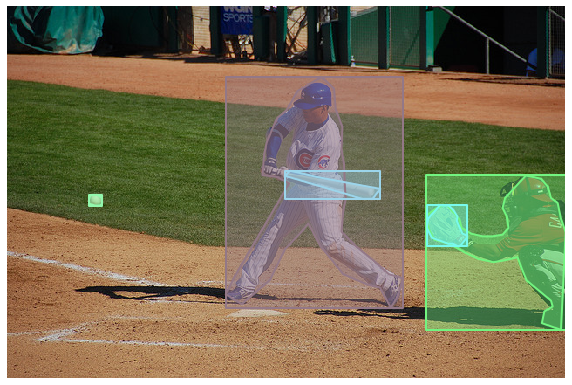

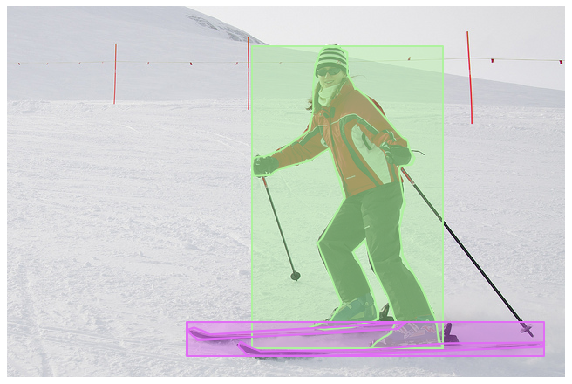

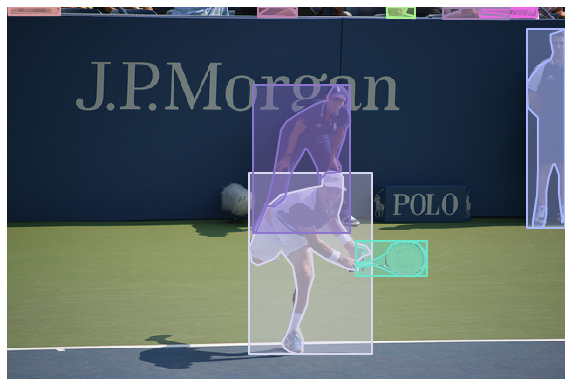

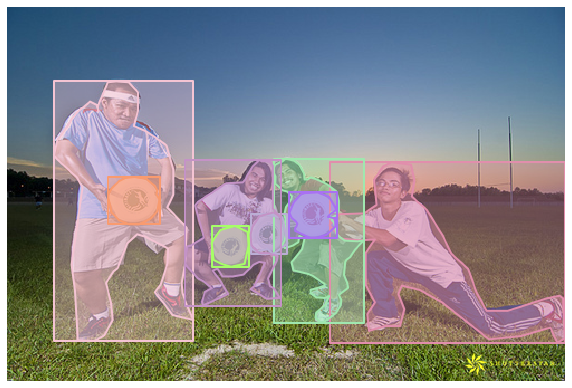

In [33]:
for file_name in image_list:
    
    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)
    for img in annotations.dataset['images']:
        if img['file_name'] == file_name.split("/")[1]:
            imgId = img['id']
            break
    anns = annotations.loadAnns(annotations.getAnnIds(imgIds=[imgId]))
    plt.imshow(image)
    plt.axis('off')
    showAnns(img, anns, draw_bbox=True)


### Now we know the annotations, we can building the dataset.

In [34]:
import torch.utils.data as Data


class CustomCOCODataset(Data.Dataset):
    
    CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
               'train', 'truck', 'boat', 'traffic_light', 'fire_hydrant',
               'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog',
               'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
               'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
               'skis', 'snowboard', 'sports_ball', 'kite', 'baseball_bat',
               'baseball_glove', 'skateboard', 'surfboard', 'tennis_racket',
               'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
               'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
               'hot_dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted_plant', 'bed', 'dining_table', 'toilet', 'tv', 'laptop',
               'mouse', 'remote', 'keyboard', 'cell_phone', 'microwave',
               'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
               'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush')
    
    def __init__(self,
                 img_list,
                 annotations):
        
        self.images = []
        self.img_metas = []
        self.gt_bboxes = []
        self.gt_labels = []
        self.gt_bboxes_ignore = []
        scale = (1333, 800)
        self.cat_ids = annotations.getCatIds()
        self.cat2label = {cat_id: i + 1 for i, cat_id in enumerate(self.cat_ids)}

        for img in img_list:
            file_name = img.split("/")[1]

            for i in annotations.dataset['images']:
                if i['file_name'] == file_name:
                    imgId = i['id']
                    anns = annotations.loadAnns(annotations.getAnnIds(imgIds=[imgId]))
                    bboxes = []
                    labels = []
                    bboxes_ignore = []

                    for i, ann in enumerate(anns):
                        if ann.get('ignore', False):
                            continue
                        x1, y1, w, h = ann['bbox']
                        bbox = [x1, y1, x1 + w - 1, y1 + h - 1]
                        if ann.get('iscrowd', False):
                            bboxes_ignore.append(bbox)
                        else:
                            bboxes.append(bbox)
                            labels.append(self.cat2label[ann['category_id']])
                    if bboxes:
                        bboxes = np.array(bboxes, dtype=np.float32)
                        labels = np.array(labels, dtype=np.int64)
                    else:
                        bboxes = np.zeros((0, 4), dtype=np.float32)
                        labels = np.array([], dtype=np.int64)

                    if bboxes_ignore:
                        bboxes_ignore = np.array(bboxes_ignore, dtype=np.float32)
                    else:
                        bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

            img = cv2.imread(img)
            img, scale_factor = mmcv.imrescale(img, scale, return_scale=True, interpolation='bilinear')
            img_shape = img.shape
            img = mmcv.impad_to_multiple(img, 32)
            pad_shape = img.shape
            img = mmcv.imnormalize(img, mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
            bboxes = bboxes * scale_factor
            bboxes[:, 0::2] = np.clip(bboxes[:, 0::2], 0, img_shape[1] - 1)
            bboxes[:, 1::2] = np.clip(bboxes[:, 1::2], 0, img_shape[0] - 1)
            self.images.append(img)
            self.gt_bboxes.append(bboxes)
            self.gt_labels.append(labels)
            self.gt_bboxes_ignore.append(bboxes_ignore)
            self.img_metas.append(
                dict(img_shape=img_shape, 
                     pad_shape=pad_shape, 
                     img_file=file_name, 
                     scale_factor=scale_factor))

    def __len__(self):
        return len(self.img_metas)
    
    def __getitem__(self, idx):
        return (self.images[idx], 
                self.gt_bboxes[idx], 
                self.gt_labels[idx],
                self.gt_bboxes_ignore[idx],
                self.img_metas[idx])
    
    def collate_fn_train(self, batch):
        data = {}
        imgs = []
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        img_metas = []
        for (img, bboxes, labels, bboxes_ignore, img_meta) in batch:
            imgs.append(torch.FloatTensor(img).cuda())
            gt_bboxes.append(torch.FloatTensor(bboxes).cuda())
            gt_labels.append(torch.LongTensor(labels).cuda())
            gt_bboxes_ignore.append(torch.FloatTensor(bboxes_ignore).cuda())
            img_metas.append(img_meta)
        data['img'] = torch.stack(imgs)
        data['img'] = data['img'].permute(0, 3, 1, 2).contiguous()
        data['gt_bboxes'] = gt_bboxes
        data['gt_labels'] = gt_labels
        data['gt_bboxes_ignore'] = gt_bboxes_ignore
        data['img_meta'] = img_metas
        return data

    def collate_fn_test(self, batch):
        data = {}
        imgs = []
        img_metas = []
        for (img, bboxes, labels, bboxes_ignore, img_meta) in batch:
            imgs.append(torch.FloatTensor(img).cuda())
            img_metas.append(img_meta)
        data['img'] = torch.stack(imgs)
        data['img'] = data['img'].permute(0, 3, 1, 2).contiguous()
        data['img_meta'] = img_metas
        return data
        
train_dataset = CustomCOCODataset(image_list, annotations)
trainloader = Data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=train_dataset.collate_fn_train)
testloader = Data.DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate_fn_test)


In [35]:
import torch.optim as optim

class Runner(object):
    
    def __init__(self, 
                 model, 
                 dataloader, 
                 lr_schedular=None, # TODO
                 max_epoch=200,
                 logger=None):
        self.model = model.cuda()
        self.dataloader = dataloader
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.0001, momentum=0.9)
        self.lr_schedular = lr_schedular
        self.logger = logger
        self.max_epoch = max_epoch
        
    @staticmethod
    def parse_losses(losses):
        log_vars = OrderedDict()
        for loss_name, loss_value in losses.items():
            if isinstance(loss_value, torch.Tensor):
                log_vars[loss_name] = loss_value.mean()
            elif isinstance(loss_value, list):
                log_vars[loss_name] = sum(_loss.mean() for _loss in loss_value)
            else:
                raise TypeError(
                    '{} is not a tensor or list of tensors'.format(loss_name))

        loss = sum(_value for _key, _value in log_vars.items() if 'loss' in _key)

        log_vars['loss'] = loss
        for loss_name, loss_value in log_vars.items():
            # reduce loss when distributed training
#             if dist.is_available() and dist.is_initialized():
#                 loss_value = loss_value.data.clone()
#                 dist.all_reduce(loss_value.div_(dist.get_world_size()))
            log_vars[loss_name] = loss_value.item()

        return loss, log_vars

    def print_loss(self, epoch, i, log_vars):
        assert isinstance(log_vars, (dict, OrderedDict))
        loss_str = "Epoch: [{:03d}/{}] |".format(epoch, self.max_epoch)
        loss_str += "Iter: [{}/{}] |".format(i+1, len(self.dataloader))
        loss_str += "|".join("{}: {:.04f}".format(
            name, value) for name, value in log_vars.items())
        print(loss_str)
        
    def batch_processor(self, data, train_mode=True):
        """Process a data batch.
        This method is required as an argument of Runner, which defines how to
        process a data batch and obtain proper outputs. 
        Args:
            data (dict): The data batch in a dict.
            train_mode (bool): Training mode or not. It may be useless for some
                models.
        Returns:
            dict: A dict containing losses and log vars.
        """
        if train_mode:
            losses = self.model(**data)
            loss, log_vars = self.parse_losses(losses)

            outputs = dict(
                loss=loss, log_vars=log_vars, num_samples=len(data['img'].data))
        else:
            outputs = self.model(**data, return_loss=False)

        return outputs
    
    @staticmethod
    def tensor2imgs(tensor, mean=(0, 0, 0), std=(1, 1, 1), to_rgb=True):
        num_imgs = tensor.size(0)
        mean = np.array(mean, dtype=np.float32)
        std = np.array(std, dtype=np.float32)
        imgs = []
        for img_id in range(num_imgs):
            img = tensor[img_id, ...].cpu().numpy().transpose(1, 2, 0)
            img = mmcv.imdenormalize(
                img, mean, std, to_bgr=to_rgb).astype(np.uint8)
            imgs.append(np.ascontiguousarray(img))
        return imgs
    
    @staticmethod
    def imshow_det_bboxes(img,
                          bboxes,
                          labels,
                          class_names=None,
                          score_thr=0,
                          bbox_color='green',
                          text_color='green',
                          thickness=1,
                          font_scale=0.5,
                          show=True,
                          out_file=None):
        """Draw bboxes and class labels (with scores) on an image.
        Args:
            img (str or ndarray): The image to be displayed.
            bboxes (ndarray): Bounding boxes (with scores), shaped (n, 4) or
                (n, 5).
            labels (ndarray): Labels of bboxes.
            class_names (list[str]): Names of each classes.
            score_thr (float): Minimum score of bboxes to be shown.
            bbox_color (str or tuple or :obj:`Color`): Color of bbox lines.
            text_color (str or tuple or :obj:`Color`): Color of texts.
            thickness (int): Thickness of lines.
            font_scale (float): Font scales of texts.
            show (bool): Whether to show the image.
            win_name (str): The window name.
            wait_time (int): Value of waitKey param.
            out_file (str or None): The filename to write the image.
        """
        assert bboxes.ndim == 2
        assert labels.ndim == 1
        assert bboxes.shape[0] == labels.shape[0]
        assert bboxes.shape[1] == 4 or bboxes.shape[1] == 5

        if score_thr > 0:
            assert bboxes.shape[1] == 5
            scores = bboxes[:, -1]
            inds = scores > score_thr
            bboxes = bboxes[inds, :]
            labels = labels[inds]

        bbox_color = (0, 255, 0)
        text_color = (0, 255, 0)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        polygons = []
        color = []

        for bbox, label in zip(bboxes, labels):
            bbox_int = bbox.astype(np.int32)
            label_text = class_names[
                label] if class_names is not None else 'cls {}'.format(label)
            if len(bbox) > 4:
                label_text += '|{:.02f}'.format(bbox[-1])
             
            if len(bbox) > 4:
                [x1, y1, x2, y2] = bbox_int[:-1]
            else:
                [x1, y1, x2, y2] = bbox_int
            cv2.putText(img, label_text, (x1, y1 - 2),
                        cv2.FONT_HERSHEY_COMPLEX, font_scale, text_color)
                
            poly = [[x1, y1], [x1, y2], [x2, y2], [x2, y1]]
            np_poly = np.array(poly).reshape((4, 2))
            polygons.append(Polygon(np_poly))
            c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
            color.append(c)
        
        img = img /255.
        plt.imshow(img)
        plt.axis('off')
        ax = plt.gca()
        ax.set_autoscale_on(False)
        p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)
        plt.show()
    
    def show_result(self, data, result, score_thr=0.3):

        bbox_result = result
        img_tensor = data['img']
        img_meta = data['img_meta'][0]
        img = self.tensor2imgs(img_tensor, mean=[123.675, 116.28, 103.53], 
                               std=[58.395, 57.12, 57.375], to_rgb=True)
        img = img[0]
        class_names = self.dataloader.dataset.CLASSES

        h, w, _ = img_meta['img_shape']
        img_show = img[:h, :w, :]

        bboxes = np.vstack(bbox_result)

        # draw bounding boxes
        labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(bbox_result)
        ]
        labels = np.concatenate(labels)
            
        self.imshow_det_bboxes(
            img_show,
            bboxes,
            labels,
            class_names=class_names,
            score_thr=score_thr)
    
    def train_detector(self):
        self.model.train()
        epoch = 1
        while epoch <= self.max_epoch:
            for i, batch in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                outputs = self.batch_processor(batch)
                outputs['loss'].backward()
                self.optimizer.step()
                self.print_loss(epoch, i, outputs['log_vars'])
            epoch += 1
        return self.model
    
    def test_detector(self, testloader, show=False):
        self.model.eval()
        for i, batch in enumerate(testloader):
            with torch.no_grad():            
                outputs = self.batch_processor(batch, train_mode=False)
            if show:
                self.show_result(batch, outputs)
                plt.close()
            


In [36]:
runner = Runner(faster_rcnn, trainloader)
runner.train_detector()

Epoch: [001/200] |Iter: [1/2] |loss_rpn_cls: 0.6912|loss_rpn_bbox: 0.1520|loss_cls: 4.5333|acc: 0.0977|loss_bbox: 0.0287|loss: 5.4052
Epoch: [001/200] |Iter: [2/2] |loss_rpn_cls: 0.6899|loss_rpn_bbox: 0.0387|loss_cls: 4.4492|acc: 0.1953|loss_bbox: 0.0497|loss: 5.2276
Epoch: [002/200] |Iter: [1/2] |loss_rpn_cls: 0.6888|loss_rpn_bbox: 0.0387|loss_cls: 4.3363|acc: 0.4883|loss_bbox: 0.0532|loss: 5.1171
Epoch: [002/200] |Iter: [2/2] |loss_rpn_cls: 0.6930|loss_rpn_bbox: 0.1508|loss_cls: 4.2483|acc: 0.4883|loss_bbox: 0.0287|loss: 5.1207
Epoch: [003/200] |Iter: [1/2] |loss_rpn_cls: 0.6917|loss_rpn_bbox: 0.1501|loss_cls: 4.0910|acc: 3.9062|loss_bbox: 0.0287|loss: 4.9614
Epoch: [003/200] |Iter: [2/2] |loss_rpn_cls: 0.6876|loss_rpn_bbox: 0.0384|loss_cls: 3.8315|acc: 47.9492|loss_bbox: 0.0440|loss: 4.6015
Epoch: [004/200] |Iter: [1/2] |loss_rpn_cls: 0.6891|loss_rpn_bbox: 0.0184|loss_cls: 3.6151|acc: 82.1289|loss_bbox: 0.0461|loss: 4.3686
Epoch: [004/200] |Iter: [2/2] |loss_rpn_cls: 0.6886|loss_rpn

Epoch: [031/200] |Iter: [2/2] |loss_rpn_cls: 0.4329|loss_rpn_bbox: 0.0159|loss_cls: 0.2244|acc: 96.8750|loss_bbox: 0.0617|loss: 0.7349
Epoch: [032/200] |Iter: [1/2] |loss_rpn_cls: 0.4267|loss_rpn_bbox: 0.0158|loss_cls: 0.2161|acc: 97.0703|loss_bbox: 0.0560|loss: 0.7146
Epoch: [032/200] |Iter: [2/2] |loss_rpn_cls: 0.5065|loss_rpn_bbox: 0.0768|loss_cls: 0.5347|acc: 93.1641|loss_bbox: 0.1220|loss: 1.2400
Epoch: [033/200] |Iter: [1/2] |loss_rpn_cls: 0.4961|loss_rpn_bbox: 0.0814|loss_cls: 0.3941|acc: 95.0195|loss_bbox: 0.0888|loss: 1.0603
Epoch: [033/200] |Iter: [2/2] |loss_rpn_cls: 0.4096|loss_rpn_bbox: 0.0104|loss_cls: 0.3423|acc: 95.1172|loss_bbox: 0.0889|loss: 0.8511
Epoch: [034/200] |Iter: [1/2] |loss_rpn_cls: 0.3972|loss_rpn_bbox: 0.0153|loss_cls: 0.2264|acc: 96.5820|loss_bbox: 0.0716|loss: 0.7106
Epoch: [034/200] |Iter: [2/2] |loss_rpn_cls: 0.4825|loss_rpn_bbox: 0.0750|loss_cls: 0.5310|acc: 92.7734|loss_bbox: 0.1304|loss: 1.2189
Epoch: [035/200] |Iter: [1/2] |loss_rpn_cls: 0.4320|los

Epoch: [062/200] |Iter: [1/2] |loss_rpn_cls: 0.2403|loss_rpn_bbox: 0.0632|loss_cls: 0.5256|acc: 88.1836|loss_bbox: 0.2975|loss: 1.1267
Epoch: [062/200] |Iter: [2/2] |loss_rpn_cls: 0.1127|loss_rpn_bbox: 0.0109|loss_cls: 0.1605|acc: 96.1914|loss_bbox: 0.0936|loss: 0.3778
Epoch: [063/200] |Iter: [1/2] |loss_rpn_cls: 0.1139|loss_rpn_bbox: 0.0108|loss_cls: 0.1522|acc: 95.9961|loss_bbox: 0.0944|loss: 0.3713
Epoch: [063/200] |Iter: [2/2] |loss_rpn_cls: 0.2566|loss_rpn_bbox: 0.0623|loss_cls: 0.5212|acc: 87.4023|loss_bbox: 0.3034|loss: 1.1435
Epoch: [064/200] |Iter: [1/2] |loss_rpn_cls: 0.1843|loss_rpn_bbox: 0.0529|loss_cls: 0.2346|acc: 93.8477|loss_bbox: 0.1653|loss: 0.6371
Epoch: [064/200] |Iter: [2/2] |loss_rpn_cls: 0.1753|loss_rpn_bbox: 0.0198|loss_cls: 0.4242|acc: 90.3320|loss_bbox: 0.2304|loss: 0.8497
Epoch: [065/200] |Iter: [1/2] |loss_rpn_cls: 0.1091|loss_rpn_bbox: 0.0096|loss_cls: 0.3336|acc: 91.9922|loss_bbox: 0.1908|loss: 0.6430
Epoch: [065/200] |Iter: [2/2] |loss_rpn_cls: 0.2414|los

Epoch: [092/200] |Iter: [2/2] |loss_rpn_cls: 0.0858|loss_rpn_bbox: 0.0080|loss_cls: 0.2204|acc: 96.6797|loss_bbox: 0.1124|loss: 0.4266
Epoch: [093/200] |Iter: [1/2] |loss_rpn_cls: 0.2029|loss_rpn_bbox: 0.0463|loss_cls: 0.4293|acc: 85.9375|loss_bbox: 0.3825|loss: 1.0611
Epoch: [093/200] |Iter: [2/2] |loss_rpn_cls: 0.0793|loss_rpn_bbox: 0.0079|loss_cls: 0.2116|acc: 96.6797|loss_bbox: 0.1142|loss: 0.4130
Epoch: [094/200] |Iter: [1/2] |loss_rpn_cls: 0.1493|loss_rpn_bbox: 0.0396|loss_cls: 0.2324|acc: 92.3828|loss_bbox: 0.2350|loss: 0.6563
Epoch: [094/200] |Iter: [2/2] |loss_rpn_cls: 0.1354|loss_rpn_bbox: 0.0140|loss_cls: 0.4056|acc: 89.9414|loss_bbox: 0.2615|loss: 0.8165
Epoch: [095/200] |Iter: [1/2] |loss_rpn_cls: 0.1965|loss_rpn_bbox: 0.0464|loss_cls: 0.3683|acc: 89.6484|loss_bbox: 0.2877|loss: 0.8989
Epoch: [095/200] |Iter: [2/2] |loss_rpn_cls: 0.0853|loss_rpn_bbox: 0.0067|loss_cls: 0.2730|acc: 92.7734|loss_bbox: 0.2058|loss: 0.5709
Epoch: [096/200] |Iter: [1/2] |loss_rpn_cls: 0.1447|los

Epoch: [123/200] |Iter: [1/2] |loss_rpn_cls: 0.1571|loss_rpn_bbox: 0.0361|loss_cls: 0.3109|acc: 87.7930|loss_bbox: 0.3654|loss: 0.8694
Epoch: [123/200] |Iter: [2/2] |loss_rpn_cls: 0.0645|loss_rpn_bbox: 0.0055|loss_cls: 0.1803|acc: 96.7773|loss_bbox: 0.0995|loss: 0.3499
Epoch: [124/200] |Iter: [1/2] |loss_rpn_cls: 0.0635|loss_rpn_bbox: 0.0043|loss_cls: 0.2044|acc: 91.7969|loss_bbox: 0.2080|loss: 0.4802
Epoch: [124/200] |Iter: [2/2] |loss_rpn_cls: 0.1544|loss_rpn_bbox: 0.0369|loss_cls: 0.2896|acc: 92.6758|loss_bbox: 0.2608|loss: 0.7416
Epoch: [125/200] |Iter: [1/2] |loss_rpn_cls: 0.0675|loss_rpn_bbox: 0.0042|loss_cls: 0.1804|acc: 92.7734|loss_bbox: 0.1906|loss: 0.4428
Epoch: [125/200] |Iter: [2/2] |loss_rpn_cls: 0.1494|loss_rpn_bbox: 0.0367|loss_cls: 0.2939|acc: 92.9688|loss_bbox: 0.2615|loss: 0.7414
Epoch: [126/200] |Iter: [1/2] |loss_rpn_cls: 0.1170|loss_rpn_bbox: 0.0089|loss_cls: 0.2793|acc: 91.4062|loss_bbox: 0.2332|loss: 0.6385
Epoch: [126/200] |Iter: [2/2] |loss_rpn_cls: 0.0992|los

Epoch: [153/200] |Iter: [2/2] |loss_rpn_cls: 0.1105|loss_rpn_bbox: 0.0299|loss_cls: 0.2468|acc: 93.9453|loss_bbox: 0.2679|loss: 0.6550
Epoch: [154/200] |Iter: [1/2] |loss_rpn_cls: 0.0594|loss_rpn_bbox: 0.0034|loss_cls: 0.1548|acc: 95.0195|loss_bbox: 0.2014|loss: 0.4191
Epoch: [154/200] |Iter: [2/2] |loss_rpn_cls: 0.1129|loss_rpn_bbox: 0.0296|loss_cls: 0.2640|acc: 93.1641|loss_bbox: 0.2652|loss: 0.6717
Epoch: [155/200] |Iter: [1/2] |loss_rpn_cls: 0.1156|loss_rpn_bbox: 0.0293|loss_cls: 0.2515|acc: 91.9922|loss_bbox: 0.3657|loss: 0.7621
Epoch: [155/200] |Iter: [2/2] |loss_rpn_cls: 0.0540|loss_rpn_bbox: 0.0035|loss_cls: 0.1583|acc: 96.8750|loss_bbox: 0.0967|loss: 0.3125
Epoch: [156/200] |Iter: [1/2] |loss_rpn_cls: 0.1132|loss_rpn_bbox: 0.0292|loss_cls: 0.2535|acc: 93.4570|loss_bbox: 0.2670|loss: 0.6629
Epoch: [156/200] |Iter: [2/2] |loss_rpn_cls: 0.0537|loss_rpn_bbox: 0.0033|loss_cls: 0.1525|acc: 95.4102|loss_bbox: 0.1940|loss: 0.4036
Epoch: [157/200] |Iter: [1/2] |loss_rpn_cls: 0.0691|los

Epoch: [184/200] |Iter: [1/2] |loss_rpn_cls: 0.0867|loss_rpn_bbox: 0.0220|loss_cls: 0.2093|acc: 94.6289|loss_bbox: 0.2638|loss: 0.5818
Epoch: [184/200] |Iter: [2/2] |loss_rpn_cls: 0.0473|loss_rpn_bbox: 0.0028|loss_cls: 0.1044|acc: 96.3867|loss_bbox: 0.1929|loss: 0.3474
Epoch: [185/200] |Iter: [1/2] |loss_rpn_cls: 0.0761|loss_rpn_bbox: 0.0223|loss_cls: 0.2080|acc: 92.9688|loss_bbox: 0.3791|loss: 0.6855
Epoch: [185/200] |Iter: [2/2] |loss_rpn_cls: 0.0477|loss_rpn_bbox: 0.0022|loss_cls: 0.1130|acc: 97.2656|loss_bbox: 0.0717|loss: 0.2345
Epoch: [186/200] |Iter: [1/2] |loss_rpn_cls: 0.0813|loss_rpn_bbox: 0.0221|loss_cls: 0.2208|acc: 91.8945|loss_bbox: 0.3784|loss: 0.7026
Epoch: [186/200] |Iter: [2/2] |loss_rpn_cls: 0.0429|loss_rpn_bbox: 0.0021|loss_cls: 0.1198|acc: 97.0703|loss_bbox: 0.0741|loss: 0.2390
Epoch: [187/200] |Iter: [1/2] |loss_rpn_cls: 0.0479|loss_rpn_bbox: 0.0021|loss_cls: 0.1166|acc: 97.1680|loss_bbox: 0.0743|loss: 0.2410
Epoch: [187/200] |Iter: [2/2] |loss_rpn_cls: 0.0818|los

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

#### For simplicity, we will load the pre-trained weights and see the detections.

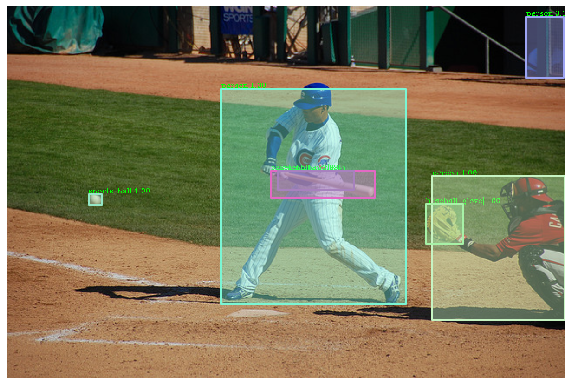

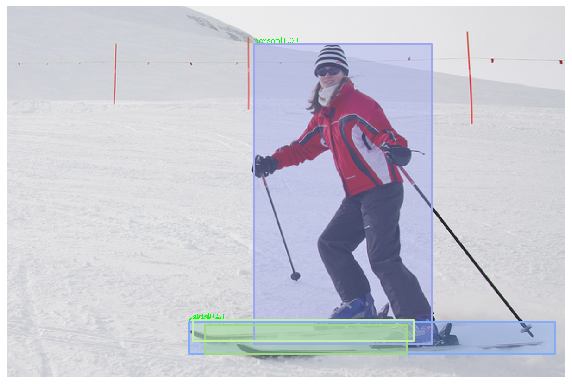

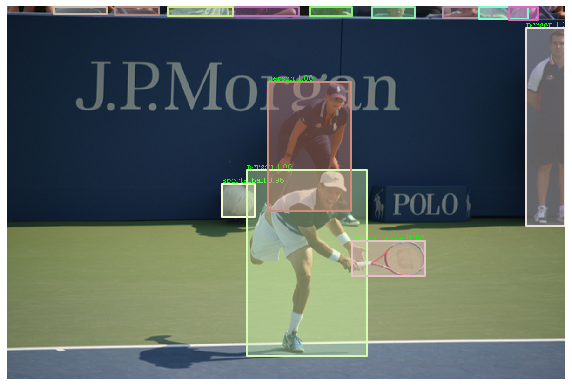

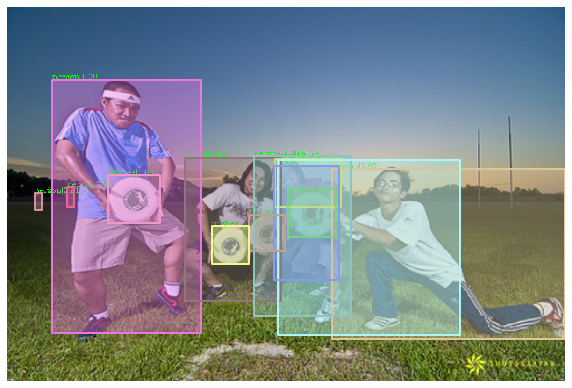

In [37]:
checkpoint = "faster_rcnn_r50_fpn_2x.pth"
checkpoint = load_checkpoint(runner.model, checkpoint, map_location=torch.device('cuda'))
runner.test_detector(testloader, show=True)